In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingRegressor, BaggingClassifier,
    GradientBoostingRegressor, GradientBoostingClassifier,
    StackingRegressor, StackingClassifier
)
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from pycaret.classification import *

In [2]:
# Загрузка данных
data_reg = pd.read_csv('data_regression.csv')
data_clf = pd.read_csv('data_classification.csv')

In [3]:
# Разделение на признаки и целевую переменную
# Для регрессии
x_reg = data_reg.drop(columns=['price'])
y_reg = data_reg['price']

# Для классификации
smote = SMOTE(random_state=42)

x_clf = data_clf.drop(columns=['num'])
y_clf = data_clf['num']

x_clf, y_clf = smote.fit_resample(x_clf, y_clf)

# Разделение данных (hold-out)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.2, random_state=42)
x_train_clf, x_test_clf, y_train_clf, y_test_clf = train_test_split(x_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

# Разделение данных (k-fold)
kf = KFold(n_splits=1, shuffle=True, random_state=42)
for train_index, test_index in kf.split(x_reg):
    X_train_reg, X_test_reg = x_reg.iloc[train_index], x_reg.iloc[test_index]
    Y_train_reg, Y_test_reg = y_reg.iloc[train_index], y_reg.iloc[test_index]
    break  # Берем только первый сплит для примера

for train_index, test_index in kf.split(x_clf):
    X_train_clf, X_test_clf = x_clf.iloc[train_index], x_clf.iloc[test_index]
    Y_train_clf, Y_test_clf = y_clf.iloc[train_index], y_clf.iloc[test_index]
    break  # Берем только первый сплит для примера

Подбор гиперпараметров для DecisionTreeRegressor

In [4]:
# Инициализация модели
dt_regressor = DecisionTreeRegressor(random_state=42)

# Параметры для поиска
params = {
    'max_depth': [2, 5, 8, 12, 16, 24, 32],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5, 7, 9, 10],
    'criterion': ['squared_error']
}
# RandomizedSearch
random_search = RandomizedSearchCV(
    dt_regressor,
    params,
    cv=5,
    n_iter=50,  # Проверит 50 случайных комбинаций
    scoring='neg_mean_squared_error',
    random_state=42,
)

random_search.fit(x_train_reg, y_train_reg)
print(f"Лучшие параметры (RandomizedSearch): {random_search.best_params_}")
print(f"Лучшая MSE: {-random_search.best_score_:.4f}")

# GridSearch
grid_search = GridSearchCV(
    dt_regressor,
    params,
    cv=5,
    scoring='neg_mean_squared_error',
)
grid_search.fit(x_train_reg, y_train_reg)
print(f"Лучшие параметры (GridSearch): {grid_search.best_params_}")
print(f"Лучшая MSE: {-grid_search.best_score_:.4f}")

Лучшие параметры (RandomizedSearch): {'min_samples_split': 10, 'min_samples_leaf': 7, 'max_depth': 12, 'criterion': 'squared_error'}
Лучшая MSE: 278347.6315
Лучшие параметры (GridSearch): {'criterion': 'squared_error', 'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 2}
Лучшая MSE: 278347.6315


[I 2025-05-21 19:28:15,830] A new study created in memory with name: no-name-6ac91c69-8453-418f-8bed-94473725a37b


Регрессия: DecisionTree


[I 2025-05-21 19:28:16,081] Trial 0 finished with value: 252109.8262059813 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'squared_error'}. Best is trial 0 with value: 252109.8262059813.
[I 2025-05-21 19:28:16,162] Trial 1 finished with value: 1651483.2128499788 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'poisson'}. Best is trial 0 with value: 252109.8262059813.
[I 2025-05-21 19:28:16,625] Trial 2 finished with value: 348257.7439204991 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'poisson'}. Best is trial 0 with value: 252109.8262059813.
[I 2025-05-21 19:28:16,958] Trial 3 finished with value: 267511.8266460767 and parameters: {'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'poisson'}. Best is trial 0 with value: 252109.8262059813.
[I 2025-05-21 19:28:17,270] Trial 4 finished with value: 300391.1013136213 and pa

R²: 0.9780


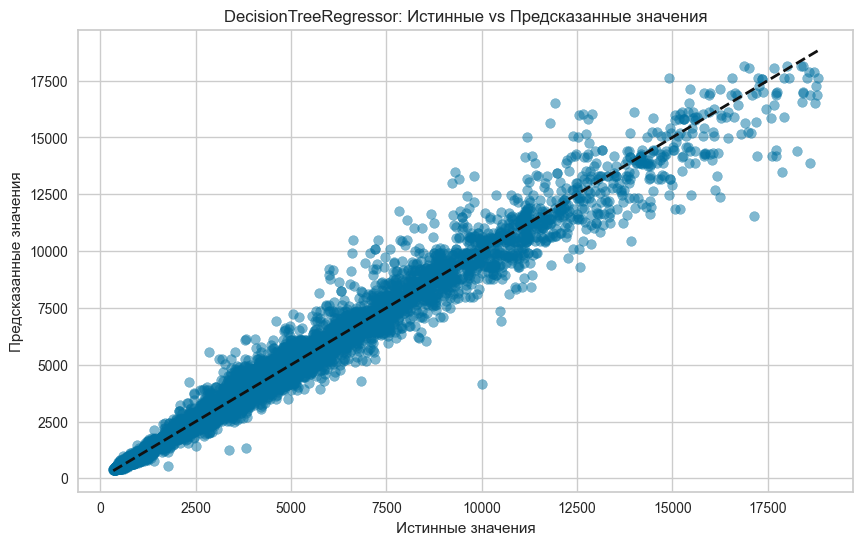

In [5]:
# Функции для подбора гиперпараметров
def optimize_decision_tree_regressor(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'poisson'])
        }
        
        model = DecisionTreeRegressor(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

# Регрессия: Дерево решений
print("Регрессия: DecisionTree")
best_params_reg = optimize_decision_tree_regressor(x_train_reg, y_train_reg, x_test_reg, y_test_reg)

dt_reg = DecisionTreeRegressor(**best_params_reg, random_state=42)
dt_reg.fit(x_train_reg, y_train_reg)
y_pred_reg = dt_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('DecisionTreeRegressor: Истинные vs Предсказанные значения')
plt.show()

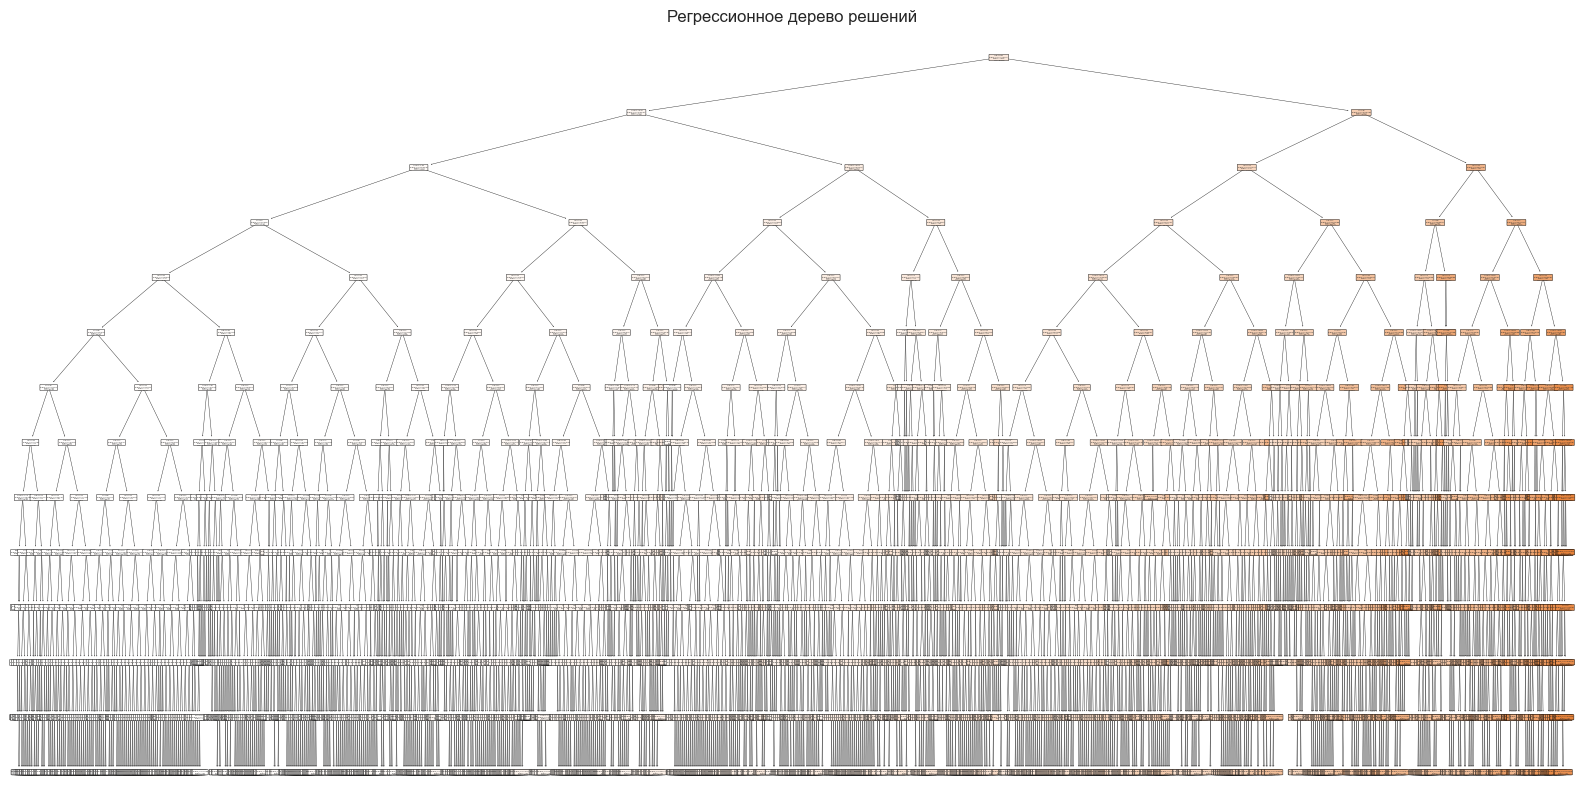

Решающие правила:
 |--- carat <= 0.99
|   |--- volume <= 102.20
|   |   |--- volume <= 75.17
|   |   |   |--- x <= 4.62
|   |   |   |   |--- clarity <= 6.50
|   |   |   |   |   |--- x <= 4.30
|   |   |   |   |   |   |--- x <= 4.13
|   |   |   |   |   |   |   |--- clarity <= 5.50
|   |   |   |   |   |   |   |   |--- volume <= 38.22
|   |   |   |   |   |   |   |   |   |--- table <= 60.50
|   |   |   |   |   |   |   |   |   |   |--- x <= 3.86
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- x >  3.86
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- table >  60.50
|   |   |   |   |   |   |   |   |   |   |--- value: [359.31]
|   |   |   |   |   |   |   |   |--- volume >  38.22
|   |   |   |   |   |   |   |   |   |--- cut <= 3.50
|   |   |   |   |   |   |   |   |   |   |--- volume <= 39.60
|   |   |   |   |   |   |   |   |   |   |   |--- truncated bran

In [6]:
plt.figure(figsize=(20,10))
plot_tree(dt_reg, 
          feature_names=list(x_train_reg.columns),
          filled=True, 
          rounded=True,
          proportion=True)
plt.title("Регрессионное дерево решений")
plt.show()

# 2. Текстовые правила
tree_rules = export_text(dt_reg, 
                        feature_names=list(x_train_reg.columns))
print("Решающие правила:\n", tree_rules)

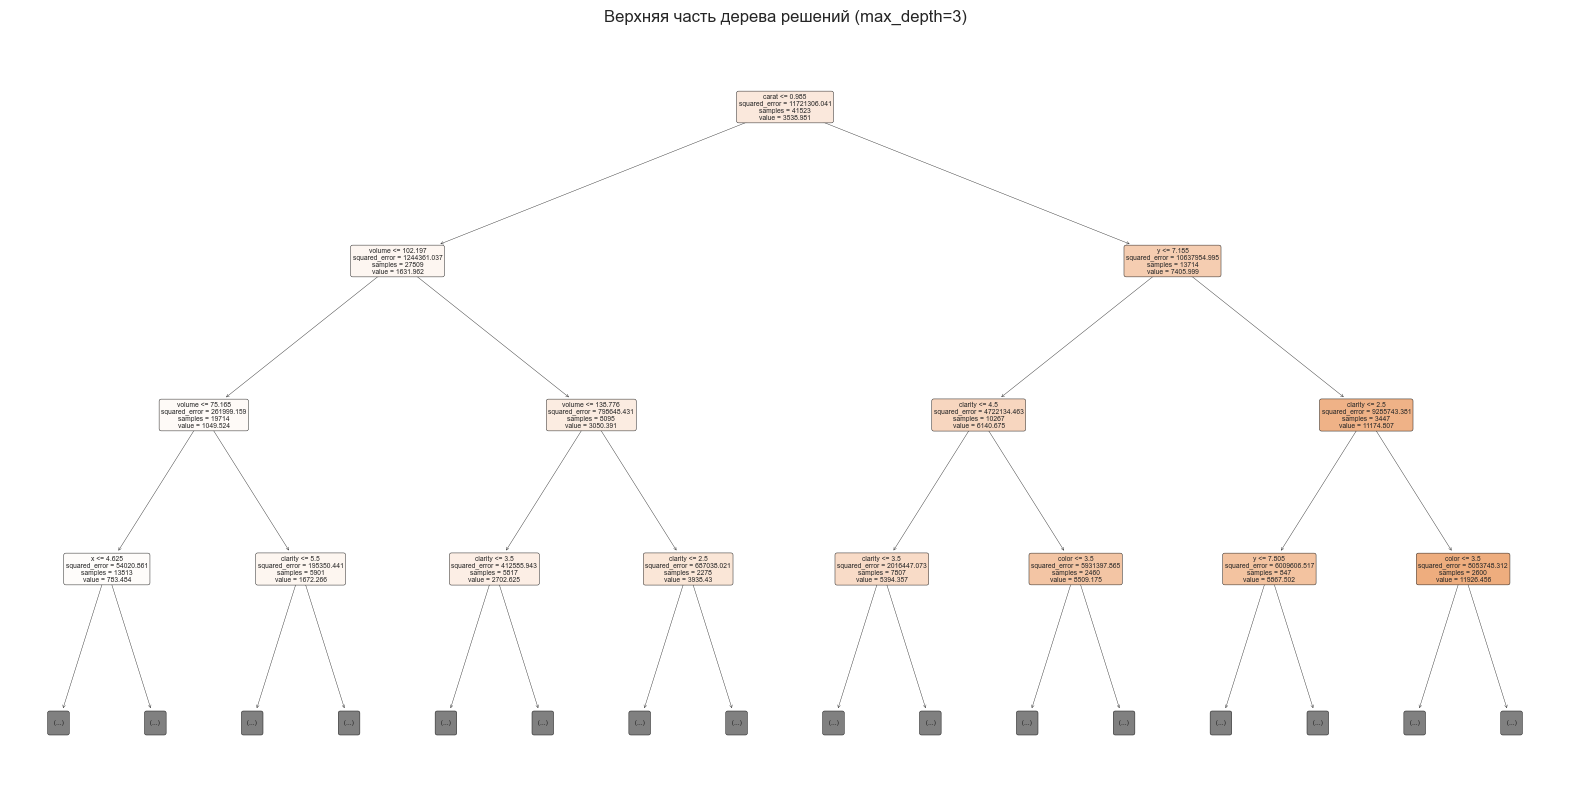

In [7]:
plt.figure(figsize=(20, 10), dpi=100)
plot_tree(dt_reg,
          feature_names=list(x_train_reg.columns),
          filled=True,
          rounded=True,
          max_depth=3,     # Показывает только первые 3 уровня
          proportion=False)
plt.title("Верхняя часть дерева решений (max_depth=3)")
plt.show()

Подбор гиперпараметров для DecisionTreeClassifier

In [8]:
# Инициализация модели
dt_classifier = DecisionTreeClassifier(random_state=42)

# Параметры для поиска
params = {
    'max_depth': [2, 5, 8, 12, 16, 24, 32],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 3, 5, 7, 9, 10],
    'criterion': ['gini', 'entropy', 'log_loss']
}
# RandomizedSearch
random_search = RandomizedSearchCV(
    dt_classifier,
    params,
    cv=5,
    n_iter=50,  # Проверит 50 случайных комбинаций
    scoring='neg_log_loss',
    random_state=42,
)

random_search.fit(x_train_clf, y_train_clf)
print(f"Лучшие параметры (RandomizedSearch): {random_search.best_params_}")
print(f"Лучшая MSE: {-random_search.best_score_:.4f}")

# GridSearch
grid_search = GridSearchCV(
    dt_classifier,
    params,
    cv=5,
    scoring='neg_log_loss',
)
grid_search.fit(x_train_clf, y_train_clf)
print(f"Лучшие параметры (GridSearch): {grid_search.best_params_}")
print(f"Лучшая MSE: {-grid_search.best_score_:.4f}")

Лучшие параметры (RandomizedSearch): {'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 2, 'criterion': 'gini'}
Лучшая MSE: 1.4276
Лучшие параметры (GridSearch): {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Лучшая MSE: 1.4276


[I 2025-05-21 19:31:25,249] A new study created in memory with name: no-name-c27790ab-ea64-47aa-92fa-bd16e7b0c4b6
[I 2025-05-21 19:31:25,257] Trial 0 finished with value: 0.38125 and parameters: {'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 0 with value: 0.38125.
[I 2025-05-21 19:31:25,265] Trial 1 finished with value: 0.575 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.38125.
[I 2025-05-21 19:31:25,274] Trial 2 finished with value: 0.34375 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 2, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.34375.
[I 2025-05-21 19:31:25,283] Trial 3 finished with value: 0.38125 and parameters: {'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 7, 'criterion': 'log_loss'}. Best is trial 2 with value: 0.34375.
[I 2025-05-21 19:31:25,292] Trial 4 finished with value:

Классификация: DecisionTree


[I 2025-05-21 19:31:25,433] Trial 13 finished with value: 0.3125 and parameters: {'max_depth': 23, 'min_samples_split': 7, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 5 with value: 0.28125.
[I 2025-05-21 19:31:25,457] Trial 14 finished with value: 0.35624999999999996 and parameters: {'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 5 with value: 0.28125.
[I 2025-05-21 19:31:25,483] Trial 15 finished with value: 0.33125000000000004 and parameters: {'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 5 with value: 0.28125.
[I 2025-05-21 19:31:25,506] Trial 16 finished with value: 0.35 and parameters: {'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 5 with value: 0.28125.
[I 2025-05-21 19:31:25,531] Trial 17 finished with value: 0.33125000000000004 and parameters: {'max_depth': 26, 'min_samples_split': 7, 'min_samp

R²: 0.6094


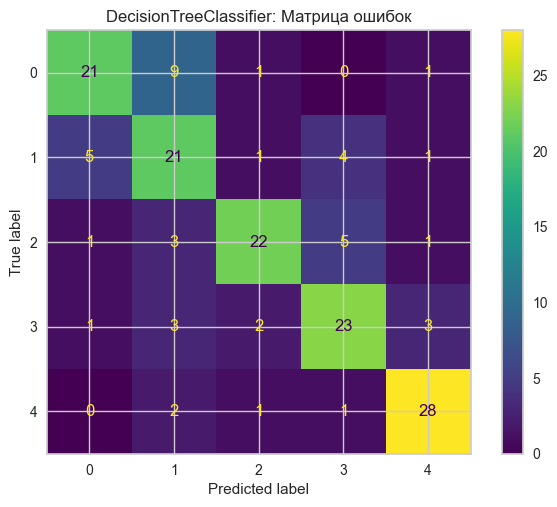

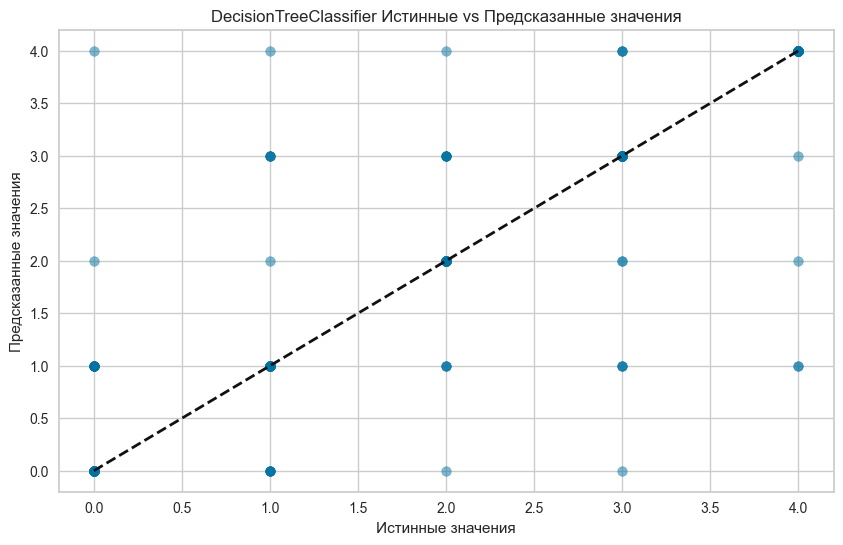

In [9]:
def optimize_decision_tree_classifier(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 2, 32),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
        }
        
        model = DecisionTreeClassifier(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

# Классификация: Дерево решений
print("Классификация: DecisionTree")
best_params_clf = optimize_decision_tree_classifier(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
dt_clf = DecisionTreeClassifier(**best_params_clf, random_state=42)
dt_clf.fit(x_train_clf, y_train_clf)
y_pred_clf = dt_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('DecisionTreeClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('DecisionTreeClassifier Истинные vs Предсказанные значения')
plt.show()

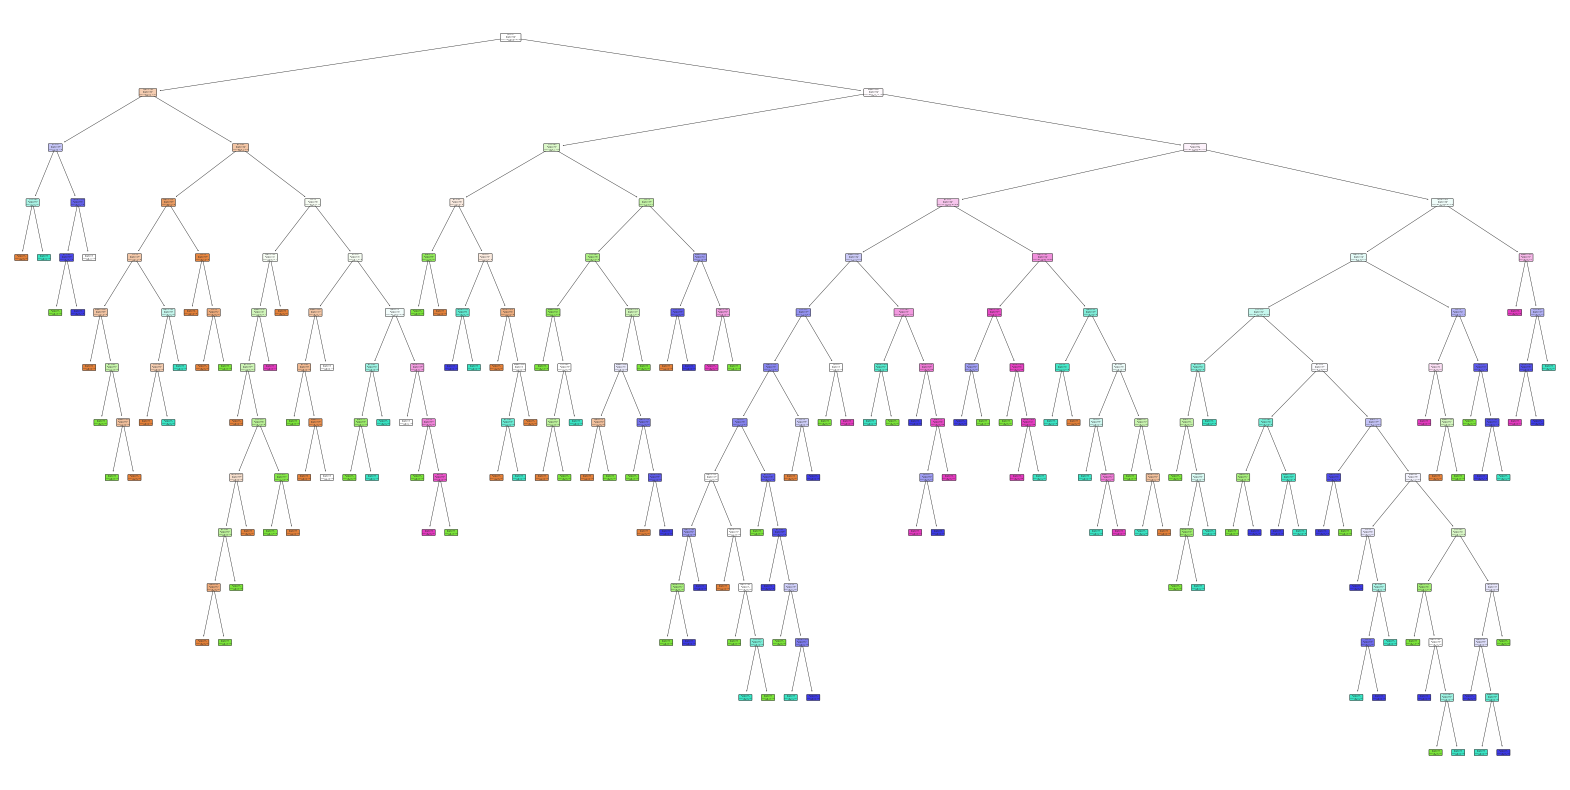

Решающие правила:
 |--- thal <= 3.50
|   |--- thalach <= 120.50
|   |   |--- sex <= 0.50
|   |   |   |--- chol <= 256.50
|   |   |   |   |--- class: 0
|   |   |   |--- chol >  256.50
|   |   |   |   |--- class: 2
|   |   |--- sex >  0.50
|   |   |   |--- trestbps <= 143.00
|   |   |   |   |--- age <= 49.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- age >  49.00
|   |   |   |   |   |--- class: 3
|   |   |   |--- trestbps >  143.00
|   |   |   |   |--- class: 1
|   |--- thalach >  120.50
|   |   |--- age <= 55.50
|   |   |   |--- thalach <= 157.50
|   |   |   |   |--- cp <= 3.50
|   |   |   |   |   |--- oldpeak <= 0.62
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- oldpeak >  0.62
|   |   |   |   |   |   |--- age <= 50.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- age >  50.00
|   |   |   |   |   |   |   |--- oldpeak <= 1.02
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- oldpeak >  1.02
|   |   |   | 

In [10]:
plt.figure(figsize=(20,10))
plot_tree(dt_clf, 
          feature_names=list(x_train_clf.columns), 
          class_names=list(map(str, dt_clf.classes_)),
          filled=True, 
          rounded=True)
plt.show()

tree_rules = export_text(dt_clf, 
                        feature_names=list(x_train_clf.columns))
print("Решающие правила:\n", tree_rules)

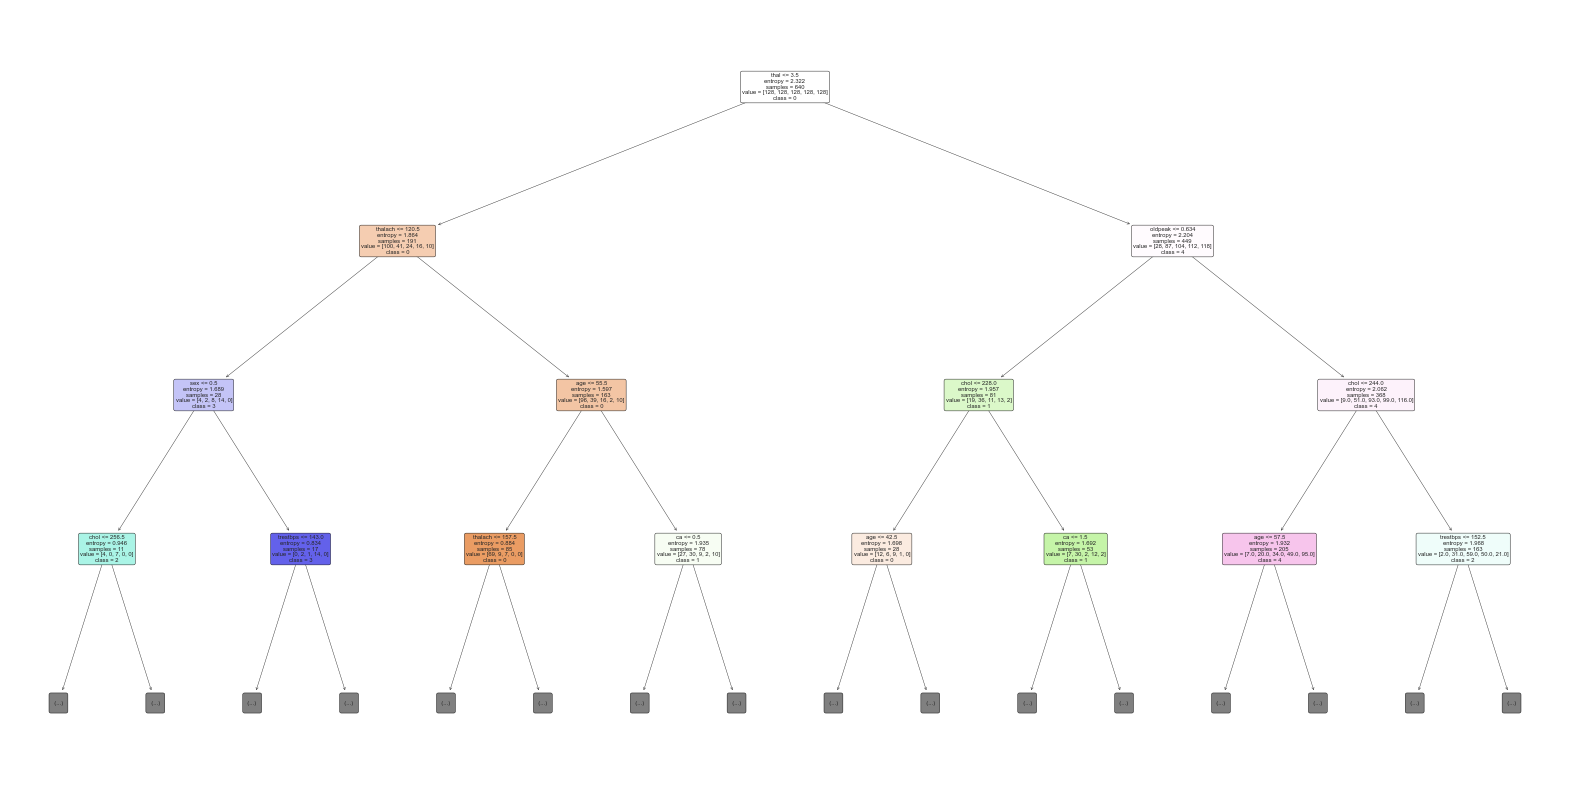

In [11]:
plt.figure(figsize=(20,10))
plot_tree(dt_clf, 
          feature_names=list(x_train_clf.columns), 
          class_names=list(map(str, dt_clf.classes_)),
          filled=True,
          max_depth=3,
          rounded=True)
plt.show()

Ансамбли

Подбор гиперпараметров BaggingRegressor

In [12]:
base_estimator = DecisionTreeRegressor(**best_params_reg, random_state=42)

bagging_reg = BaggingRegressor(estimator=base_estimator, random_state=42)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.1, 0.5, 1.0],
    'max_features': [1, 5, 10],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    bagging_reg,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_mean_squared_error',
    random_state=42
)
random_search.fit(x_train_reg, y_train_reg)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    bagging_reg,
    params,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(x_train_reg, y_train_reg)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 10}
RandomSearch лучшая MSE: 225294.5050
GridSearch лучшие параметры: {'max_features': 10, 'max_samples': 1.0, 'n_estimators': 50}
GridSearch лучшая MSE: 225294.5050


RandomSearch лучшие параметры: {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 10}
RandomSearch лучшая MSE: 225338.6233
GridSearch лучшие параметры: {'max_features': 10, 'max_samples': 1.0, 'n_estimators': 50}
GridSearch лучшая MSE: 225338.6233

In [13]:
def optimize_bagging_regressor(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        }
        model = BaggingRegressor(
            estimator=DecisionTreeRegressor(**best_params_reg, random_state=42),
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_bagging_reg_an = optimize_bagging_regressor(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
bagging_reg = BaggingRegressor(**best_bagging_reg_an, random_state=42)
bagging_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-21 19:53:37,733] A new study created in memory with name: no-name-fff02121-4c72-4cce-a263-40434686f345
[I 2025-05-21 19:53:46,577] Trial 0 finished with value: 292014.74998868146 and parameters: {'n_estimators': 81, 'max_samples': 0.9556428757689246, 'max_features': 0.7587945476302645}. Best is trial 0 with value: 292014.74998868146.
[I 2025-05-21 19:53:47,902] Trial 1 finished with value: 2134608.79578752 and parameters: {'n_estimators': 124, 'max_samples': 0.24041677639819287, 'max_features': 0.2403950683025824}. Best is trial 0 with value: 292014.74998868146.
[I 2025-05-21 19:53:49,801] Trial 2 finished with value: 427230.34921416163 and parameters: {'n_estimators': 21, 'max_samples': 0.8795585311974417, 'max_features': 0.6410035105688879}. Best is trial 0 with value: 292014.74998868146.
[I 2025-05-21 19:53:53,646] Trial 3 finished with value: 291200.29133818723 and parameters: {'n_estimators': 145, 'max_samples': 0.1185260448662222, 'max_features': 0.9729188669457949}. B

BaggingRegressor(max_features=0.9350580522430605,
                 max_samples=0.9083026898747971, n_estimators=95,
                 random_state=42)

R²: 0.9823


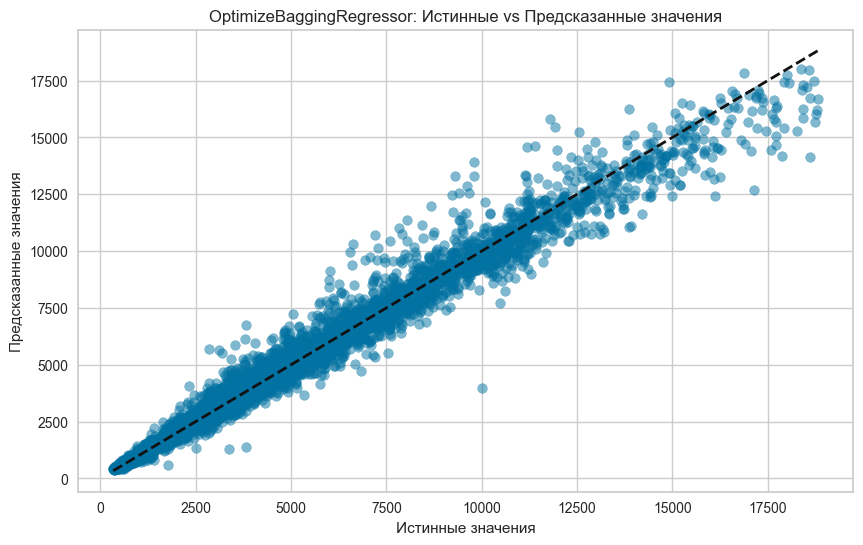

In [14]:
y_pred_bagging_reg = bagging_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_bagging_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_bagging_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('OptimizeBaggingRegressor: Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров BaggingClassifier

In [15]:
base_estimator = DecisionTreeClassifier(**best_params_clf, random_state=42)

bagging_clf = BaggingClassifier(estimator=base_estimator, random_state=42)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.1, 0.5, 1.0],
    'max_features': [0.1, 0.5, 1.0],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    bagging_clf,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_log_loss',
    random_state=42
)
random_search.fit(x_train_clf, y_train_clf)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    bagging_clf,
    params,
    cv=5,
    scoring='neg_log_loss'
)
grid_search.fit(x_train_clf, y_train_clf)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0}
RandomSearch лучшая MSE: 0.5686
GridSearch лучшие параметры: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
GridSearch лучшая MSE: 0.5686


RandomSearch лучшие параметры: {'n_estimators': 50, 'max_samples': 1.0, 'max_features': 0.5}
RandomSearch лучшая MSE: 0.4156
GridSearch лучшие параметры: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}
GridSearch лучшая MSE: 0.4156

In [16]:
def optimize_bagging_classifier(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        }
        base_estimator = DecisionTreeClassifier(**best_params_clf, random_state=42)
        
        model = BaggingClassifier(base_estimator,
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_bagging_clf = optimize_bagging_classifier(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
bagging_clf = BaggingClassifier(**best_bagging_clf, random_state=42)
bagging_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-21 20:03:09,843] A new study created in memory with name: no-name-a14fb2f1-d8e0-4c04-9d4c-1399e468dbcf
[I 2025-05-21 20:03:10,140] Trial 0 finished with value: 0.16249999999999998 and parameters: {'n_estimators': 81, 'max_samples': 0.9556428757689246, 'max_features': 0.7587945476302645}. Best is trial 0 with value: 0.16249999999999998.
[I 2025-05-21 20:03:10,376] Trial 1 finished with value: 0.30625 and parameters: {'n_estimators': 124, 'max_samples': 0.24041677639819287, 'max_features': 0.2403950683025824}. Best is trial 0 with value: 0.16249999999999998.
[I 2025-05-21 20:03:10,448] Trial 2 finished with value: 0.18125000000000002 and parameters: {'n_estimators': 21, 'max_samples': 0.8795585311974417, 'max_features': 0.6410035105688879}. Best is trial 0 with value: 0.16249999999999998.
[I 2025-05-21 20:03:10,743] Trial 3 finished with value: 0.25625 and parameters: {'n_estimators': 145, 'max_samples': 0.1185260448662222, 'max_features': 0.9729188669457949}. Best is trial 0 

BaggingClassifier(max_features=0.5218200058759496,
                  max_samples=0.5218346969990579, n_estimators=200,
                  random_state=42)

R²: 0.7969


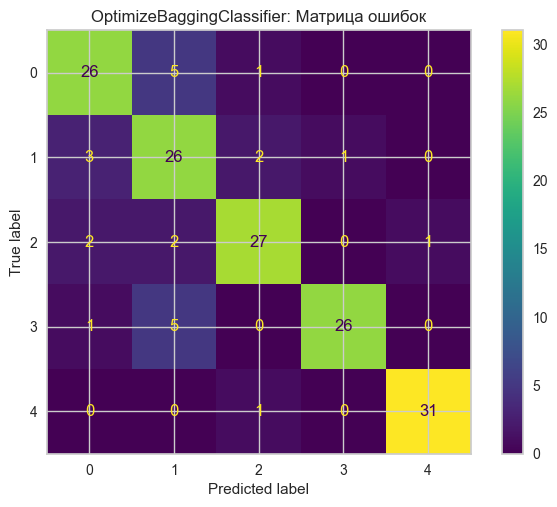

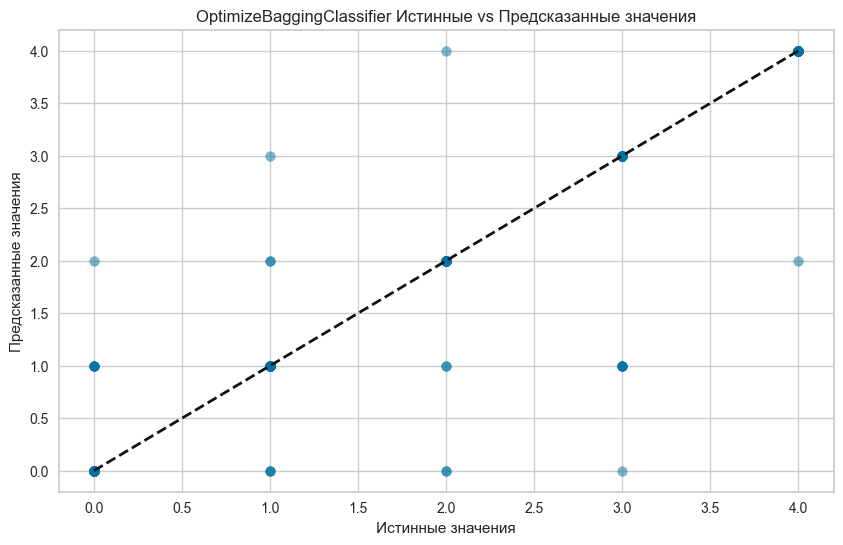

In [17]:
y_pred_bagging_clf = bagging_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_bagging_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_bagging_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('OptimizeBaggingClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_bagging_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('OptimizeBaggingClassifier Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров BaggingClassifier с Random Forest

In [18]:
base_estimator = RandomForestClassifier(n_estimators=100, random_state=42)

bagging_clf_random_forest = BaggingClassifier(estimator=base_estimator, random_state=42)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_samples': [0.1, 0.5, 1.0],
    'max_features': [0.1, 0.5, 1.0],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    bagging_clf_random_forest,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_log_loss',
    random_state=42
)
random_search.fit(x_train_clf, y_train_clf)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    bagging_clf_random_forest,
    params,
    cv=5,
    scoring='neg_log_loss'
)
grid_search.fit(x_train_clf, y_train_clf)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 200, 'max_samples': 1.0, 'max_features': 1.0}
RandomSearch лучшая MSE: 0.6651
GridSearch лучшие параметры: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}
GridSearch лучшая MSE: 0.6651


In [19]:
def optimize_bagging_classifier_random_forest(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        }
        base_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        
        model = BaggingClassifier(base_estimator,
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_bagging_clf_random_forest = optimize_bagging_classifier_random_forest(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
bagging_clf_random_forest = BaggingClassifier(**best_bagging_clf_random_forest, random_state=42)
bagging_clf_random_forest.fit(x_train_clf, y_train_clf)

[I 2025-05-21 21:09:08,410] A new study created in memory with name: no-name-550cdc24-7f52-469e-9bb7-62eb0c60033e
[I 2025-05-21 21:09:19,983] Trial 0 finished with value: 0.125 and parameters: {'n_estimators': 81, 'max_samples': 0.9556428757689246, 'max_features': 0.7587945476302645}. Best is trial 0 with value: 0.125.
[I 2025-05-21 21:09:34,077] Trial 1 finished with value: 0.28125 and parameters: {'n_estimators': 124, 'max_samples': 0.24041677639819287, 'max_features': 0.2403950683025824}. Best is trial 0 with value: 0.125.
[I 2025-05-21 21:09:36,905] Trial 2 finished with value: 0.15000000000000002 and parameters: {'n_estimators': 21, 'max_samples': 0.8795585311974417, 'max_features': 0.6410035105688879}. Best is trial 0 with value: 0.125.
[I 2025-05-21 21:09:53,168] Trial 3 finished with value: 0.26249999999999996 and parameters: {'n_estimators': 145, 'max_samples': 0.1185260448662222, 'max_features': 0.9729188669457949}. Best is trial 0 with value: 0.125.
[I 2025-05-21 21:10:12,47

BaggingClassifier(max_features=0.7587945476302645,
                  max_samples=0.9556428757689246, n_estimators=81,
                  random_state=42)

R²: 0.8031


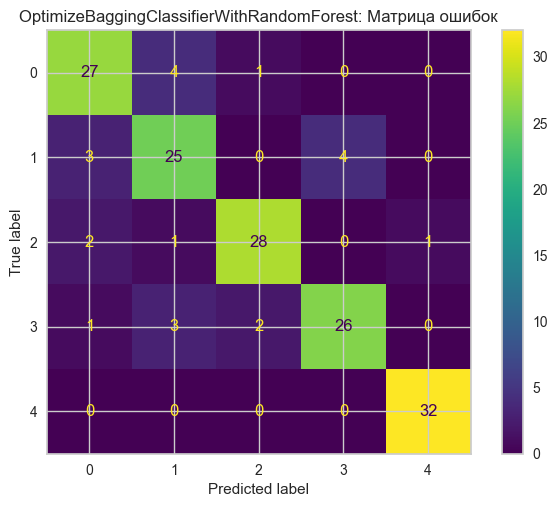

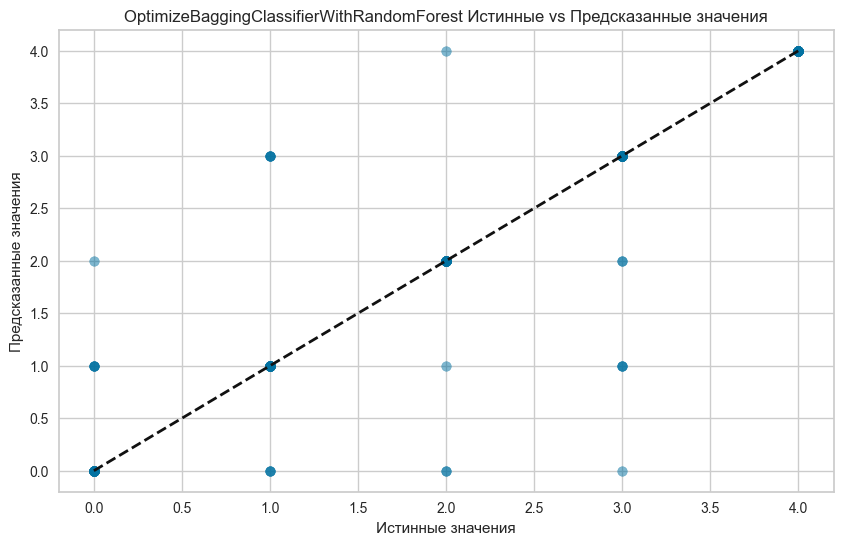

In [20]:
y_pred_bagging_clf_random_forest = bagging_clf_random_forest.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_bagging_clf_random_forest)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_bagging_clf_random_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('OptimizeBaggingClassifierWithRandomForest: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_bagging_clf_random_forest, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('OptimizeBaggingClassifierWithRandomForest Истинные vs Предсказанные значения')
plt.show()

Подбор гиперапараметров BaggingRegressor с Random Forest 

In [21]:
base_estimator = RandomForestRegressor(n_estimators=100, random_state=42)

bagging_reg_random_forest = BaggingRegressor(estimator=base_estimator, random_state=42)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10],
    'max_samples': [0.1],
    'max_features': [1],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    bagging_reg_random_forest,
    params,
    cv=5,
    n_iter=10,
    scoring='neg_mean_squared_error',
    random_state=42
)
random_search.fit(x_train_reg, y_train_reg)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    bagging_reg_random_forest,
    params,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(x_train_reg, y_train_reg)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 10, 'max_samples': 0.1, 'max_features': 1}
RandomSearch лучшая MSE: 3434929.6154
GridSearch лучшие параметры: {'max_features': 1, 'max_samples': 0.1, 'n_estimators': 10}
GridSearch лучшая MSE: 3434929.6154


In [22]:
def optimize_bagging_regressor_random_forest(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
        }
        model = BaggingRegressor(
            estimator=RandomForestRegressor(n_estimators=100, random_state=42),
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_bagging_reg_an_random_forest = optimize_bagging_regressor_random_forest(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
bagging_reg_random_forest = BaggingRegressor(**best_bagging_reg_an_random_forest, random_state=42)
bagging_reg_random_forest.fit(x_train_reg, y_train_reg)

[I 2025-05-21 21:23:04,086] A new study created in memory with name: no-name-5c71538a-f93e-4f89-8952-ff3bbee9e4fd
[I 2025-05-21 21:39:28,524] Trial 0 finished with value: 282466.3923902088 and parameters: {'n_estimators': 81, 'max_samples': 0.9556428757689246, 'max_features': 0.7587945476302645}. Best is trial 0 with value: 282466.3923902088.
[I 2025-05-21 21:41:52,468] Trial 1 finished with value: 2086303.6005402242 and parameters: {'n_estimators': 124, 'max_samples': 0.24041677639819287, 'max_features': 0.2403950683025824}. Best is trial 0 with value: 282466.3923902088.
[I 2025-05-21 21:45:23,362] Trial 2 finished with value: 411319.13272771257 and parameters: {'n_estimators': 21, 'max_samples': 0.8795585311974417, 'max_features': 0.6410035105688879}. Best is trial 0 with value: 282466.3923902088.
[I 2025-05-21 21:52:40,797] Trial 3 finished with value: 259570.5056261493 and parameters: {'n_estimators': 145, 'max_samples': 0.1185260448662222, 'max_features': 0.9729188669457949}. Best

BaggingRegressor(max_features=0.9729188669457949,
                 max_samples=0.1185260448662222, n_estimators=145,
                 random_state=42)

R²: 0.9823


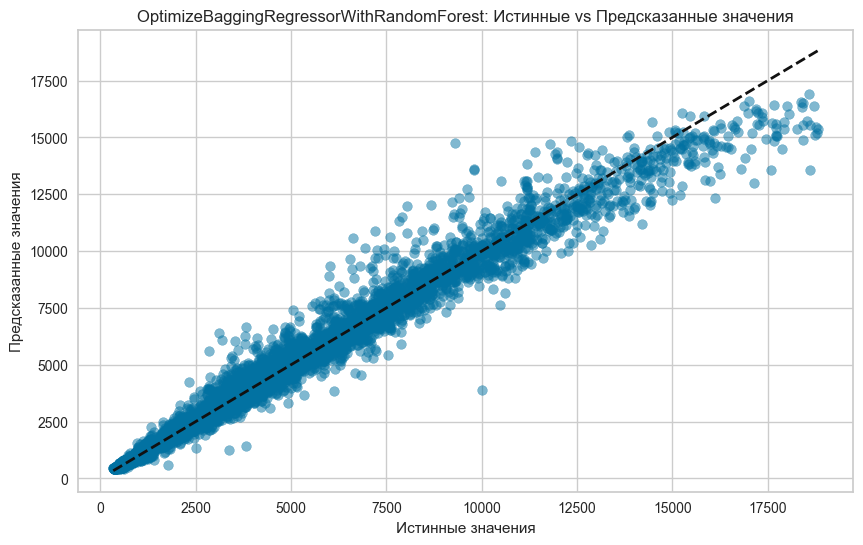

In [23]:
y_pred_bagging_reg_random_forest = bagging_reg_random_forest.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_bagging_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_bagging_reg_random_forest, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('OptimizeBaggingRegressorWithRandomForest: Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров GradientBoostingRegressor

In [24]:
base_estimator = DecisionTreeRegressor(**best_params_reg, random_state=42)

GradientBoosting_reg = GradientBoostingRegressor(
    init=DecisionTreeRegressor(**best_params_reg),
    random_state=42
)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    GradientBoosting_reg,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_mean_squared_error',
    random_state=42
)
random_search.fit(x_train_reg, y_train_reg)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    GradientBoosting_reg,
    params,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(x_train_reg, y_train_reg)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 100, 'learning_rate': 0.1}
RandomSearch лучшая MSE: 271102.8063
GridSearch лучшие параметры: {'learning_rate': 0.1, 'n_estimators': 200}
GridSearch лучшая MSE: 271276.4742


In [25]:
def optimize_GradientBoosting_reg(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        }
        base_estimator = DecisionTreeRegressor(**best_params_reg, random_state=42)
        
        model = GradientBoostingRegressor(init=DecisionTreeRegressor(**best_params_reg),
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_GradientBoosting_reg = optimize_GradientBoosting_reg(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
GradientBoosting_reg = GradientBoostingRegressor(init=DecisionTreeRegressor(**best_params_reg), **best_GradientBoosting_reg, random_state=42)
GradientBoosting_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-21 22:29:45,263] A new study created in memory with name: no-name-6d66b706-945a-41a1-a0ae-e8498694cf69
[I 2025-05-21 22:29:51,018] Trial 0 finished with value: 255759.3292988127 and parameters: {'n_estimators': 81, 'learning_rate': 0.9556428757689246}. Best is trial 0 with value: 255759.3292988127.
[I 2025-05-21 22:30:01,272] Trial 1 finished with value: 251073.1487694579 and parameters: {'n_estimators': 149, 'learning_rate': 0.6387926357773329}. Best is trial 1 with value: 251073.1487694579.
[I 2025-05-21 22:30:04,165] Trial 2 finished with value: 244028.8053537122 and parameters: {'n_estimators': 39, 'learning_rate': 0.2403950683025824}. Best is trial 2 with value: 244028.8053537122.
[I 2025-05-21 22:30:05,826] Trial 3 finished with value: 252446.21190455806 and parameters: {'n_estimators': 21, 'learning_rate': 0.8795585311974417}. Best is trial 2 with value: 244028.8053537122.
[I 2025-05-21 22:30:14,429] Trial 4 finished with value: 259647.6551404083 and parameters: {'n_e

GradientBoostingRegressor(init=DecisionTreeRegressor(max_depth=13,
                                                     min_samples_leaf=8,
                                                     min_samples_split=10),
                          learning_rate=0.198279179030247, n_estimators=179,
                          random_state=42)

R²: 0.9791


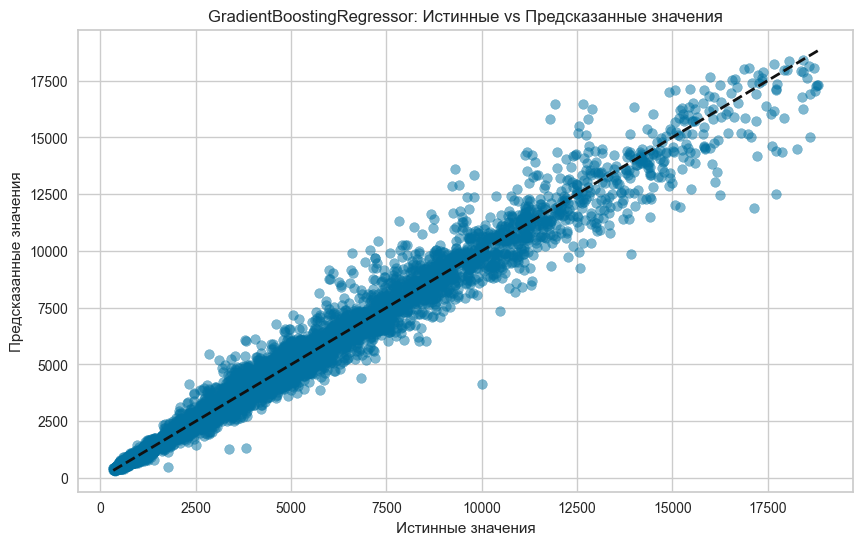

In [26]:
y_pred_GradientBoosting_reg = GradientBoosting_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_GradientBoosting_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_GradientBoosting_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('GradientBoostingRegressor: Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров GradientBoostingClassifier

In [27]:
GradientBoosting_clf = GradientBoostingClassifier(
    init=DecisionTreeClassifier(**best_params_clf),
    random_state=42
)

# 3. Параметры для поиска (исправлено)
params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    GradientBoosting_clf,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_log_loss',
    random_state=42
)
random_search.fit(x_train_clf, y_train_clf)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    GradientBoosting_clf,
    params,
    cv=5,
    scoring='neg_log_loss'
)
grid_search.fit(x_train_clf, y_train_clf)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'n_estimators': 200, 'learning_rate': 0.5}
RandomSearch лучшая MSE: 4.1572
GridSearch лучшие параметры: {'learning_rate': 1.0, 'n_estimators': 100}
GridSearch лучшая MSE: 4.1184


In [28]:
def optimize_GradientBoosting_classifier(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 200),
            'learning_rate': trial.suggest_float('learning_rate', 0.1, 1.0),
        }
        
        model = GradientBoostingClassifier(init=DecisionTreeClassifier(**best_params_clf),
            **params,
            random_state=42
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
    
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_GradientBoosting_clf = optimize_GradientBoosting_classifier(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
GradientBoosting_clf = GradientBoostingClassifier(**best_GradientBoosting_clf, random_state=42)
GradientBoosting_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-21 22:39:38,845] A new study created in memory with name: no-name-b16dd3c8-0263-487f-b24f-4fc2a8e05859
[I 2025-05-21 22:39:39,320] Trial 0 finished with value: 0.28125 and parameters: {'n_estimators': 81, 'learning_rate': 0.9556428757689246}. Best is trial 0 with value: 0.28125.
[I 2025-05-21 22:39:40,068] Trial 1 finished with value: 0.28125 and parameters: {'n_estimators': 149, 'learning_rate': 0.6387926357773329}. Best is trial 0 with value: 0.28125.
[I 2025-05-21 22:39:40,415] Trial 2 finished with value: 0.30000000000000004 and parameters: {'n_estimators': 39, 'learning_rate': 0.2403950683025824}. Best is trial 0 with value: 0.28125.
[I 2025-05-21 22:39:40,611] Trial 3 finished with value: 0.2875 and parameters: {'n_estimators': 21, 'learning_rate': 0.8795585311974417}. Best is trial 0 with value: 0.28125.
[I 2025-05-21 22:39:41,147] Trial 4 finished with value: 0.30000000000000004 and parameters: {'n_estimators': 124, 'learning_rate': 0.737265320016441}. Best is trial 

GradientBoostingClassifier(learning_rate=0.4665025629824473, n_estimators=194,
                           random_state=42)

R²: 0.6750


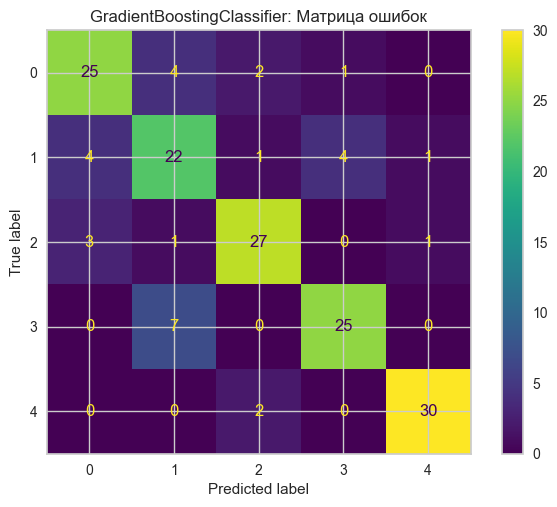

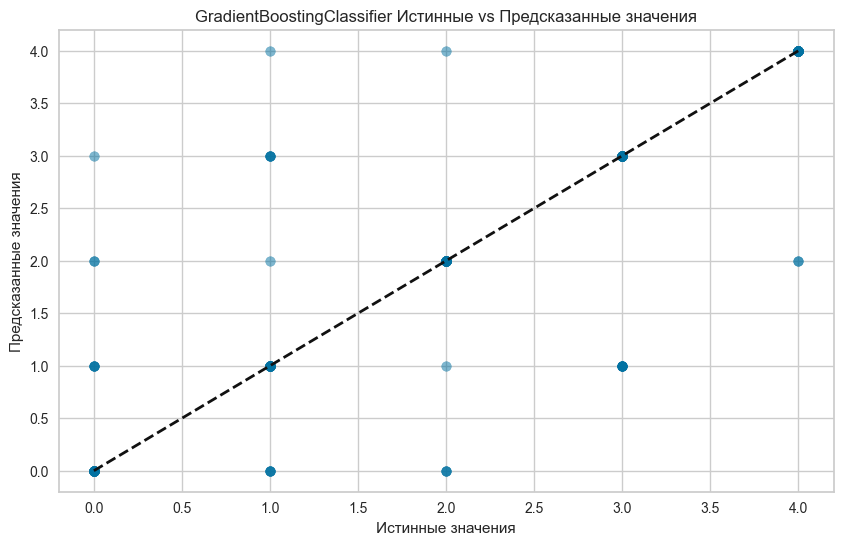

In [29]:
y_pred_GradientBoosting_clf = GradientBoosting_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_GradientBoosting_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_GradientBoosting_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('GradientBoostingClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_GradientBoosting_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('GradientBoostingClassifier Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров StackingRegressor

In [30]:
base_estimators_reg = [
    ('gb', GradientBoostingRegressor(**best_params_reg, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('ridge', Ridge(alpha=1.0))
]

base_estimator_reg = ElasticNet(alpha=1.0)

Stacking_reg = StackingRegressor(
    estimators=base_estimators_reg,
    final_estimator=base_estimator_reg
)

# 3. Параметры для поиска (исправлено)
params = {
    'passthrough': [False],
    'cv': [3],
}
##Слишком долго
##params = {
##    'passthrough': [True, False],
##    'cv': [3, 5, 10, 15],
##}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    Stacking_reg,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_mean_squared_error',
    random_state=42
)
random_search.fit(x_train_reg, y_train_reg)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    Stacking_reg,
    params,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(x_train_reg, y_train_reg)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

RandomSearch лучшие параметры: {'passthrough': False, 'cv': 3}
RandomSearch лучшая MSE: 198586.6513
GridSearch лучшие параметры: {'cv': 3, 'passthrough': False}
GridSearch лучшая MSE: 198586.6513


In [32]:
from sklearn.linear_model import ElasticNet
def optimize_Stacking_reg(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'passthrough': trial.suggest_categorical('passthrough', [True, False]),
            'cv': trial.suggest_int('cv', 3, 15),
        }
        base_estimator_reg =  ElasticNet(alpha=0.1)

        model = StackingRegressor(
            estimators=base_estimators_reg,
            final_estimator=base_estimator_reg,
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_Stacking_reg = optimize_Stacking_reg(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
Stacking_reg = StackingRegressor(
            estimators=base_estimators_reg,
            final_estimator=base_estimator_reg,
            **best_Stacking_reg
        )
Stacking_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-22 06:56:37,582] A new study created in memory with name: no-name-50afba6b-8703-4349-823e-1d467fe25602
[I 2025-05-22 07:07:16,423] Trial 0 finished with value: 189864.40329735313 and parameters: {'passthrough': False, 'cv': 12}. Best is trial 0 with value: 189864.40329735313.
[I 2025-05-22 07:11:31,294] Trial 1 finished with value: 189396.74935238063 and parameters: {'passthrough': True, 'cv': 5}. Best is trial 1 with value: 189396.74935238063.
[I 2025-05-22 07:19:58,431] Trial 2 finished with value: 189967.0246983909 and parameters: {'passthrough': False, 'cv': 10}. Best is trial 1 with value: 189396.74935238063.
[I 2025-05-22 07:32:55,282] Trial 3 finished with value: 189355.23563253772 and parameters: {'passthrough': True, 'cv': 15}. Best is trial 3 with value: 189355.23563253772.
[I 2025-05-22 07:37:11,156] Trial 4 finished with value: 189396.74935238063 and parameters: {'passthrough': True, 'cv': 5}. Best is trial 3 with value: 189355.23563253772.
[I 2025-05-22 07:44:43

StackingRegressor(cv=15,
                  estimators=[('gb',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         max_depth=13,
                                                         min_samples_leaf=8,
                                                         min_samples_split=10,
                                                         random_state=42)),
                              ('rf', RandomForestRegressor(random_state=42)),
                              ('ridge', Ridge())],
                  final_estimator=Ridge(), passthrough=True)

R²: 0.9836


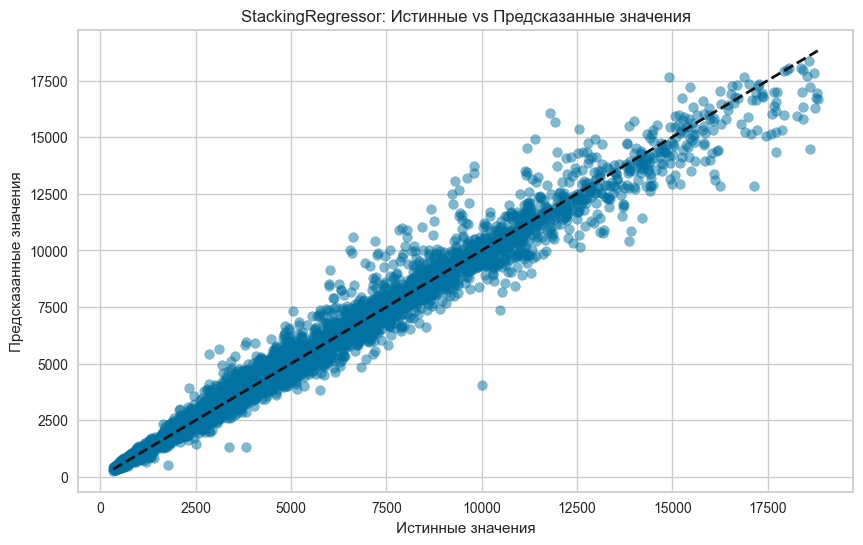

In [33]:
y_pred_Stacking_reg = Stacking_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_Stacking_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_Stacking_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('StackingRegressor: Истинные vs Предсказанные значения')
plt.show()

Подбор гиперпараметров StackingClassifier

In [ ]:
base_estimators_clf = [
    ('gb', GradientBoostingClassifier(**best_GradientBoosting_clf, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('bagging', BaggingClassifier(**best_bagging_clf, random_state=42))
]

base_estimator_clf = LogisticRegression(max_iter=1000, random_state=42)

Stacking_clf = StackingClassifier(
    estimators=base_estimators_clf,
    final_estimator=base_estimator_clf
)

# 3. Параметры для поиска (исправлено)
params = {
    'passthrough': [True, False],
    'cv': [3, 5, 15],
}
##Слишком долго
##params = {
##    'passthrough': [True, False],
##    'cv': [3, 5, 10, 15],
##}

# 4. RandomizedSearch
random_search = RandomizedSearchCV(
    Stacking_clf,
    params,
    cv=5,
    n_iter=50,
    scoring='neg_log_loss',
    random_state=42
)
random_search.fit(x_train_clf, y_train_clf)
print(f"RandomSearch лучшие параметры: {random_search.best_params_}")
print(f"RandomSearch лучшая MSE: {-random_search.best_score_:.4f}")

grid_search = GridSearchCV(
    Stacking_clf,
    params,
    cv=5,
    scoring='neg_log_loss'
)
grid_search.fit(x_train_clf, y_train_clf)
print(f"GridSearch лучшие параметры: {grid_search.best_params_}")
print(f"GridSearch лучшая MSE: {-grid_search.best_score_:.4f}")

In [35]:
base_estimators_clf = [
    ('gb', GradientBoostingClassifier(**best_GradientBoosting_clf, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('bagging', BaggingClassifier(**best_bagging_clf, random_state=42))
]

base_estimator_clf = LogisticRegression(max_iter=1000, random_state=42)

Stacking_clf = StackingClassifier(
    estimators=base_estimators_clf,
    final_estimator=base_estimator_clf
)

def optimize_Stacking_clf(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'passthrough': trial.suggest_categorical('passthrough', [True, False]),
            'cv': trial.suggest_int('cv', 3, 15),
        }
        base_estimator_clf =LogisticRegression(max_iter=1000, random_state=42)

        model = StackingClassifier(
            estimators=base_estimators_clf,
            final_estimator=base_estimator_clf,
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_Stacking_clf = optimize_Stacking_clf(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
Stacking_clf = StackingClassifier(
            estimators=base_estimators_clf,
            final_estimator=base_estimator_clf,
            **best_Stacking_clf
        )
Stacking_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-22 08:27:05,290] A new study created in memory with name: no-name-e7ff30d3-991c-46e1-a8bd-428af3943181
[I 2025-05-22 08:27:32,492] Trial 0 finished with value: 0.15625 and parameters: {'passthrough': False, 'cv': 12}. Best is trial 0 with value: 0.15625.
[I 2025-05-22 08:27:44,664] Trial 1 finished with value: 0.1875 and parameters: {'passthrough': True, 'cv': 5}. Best is trial 0 with value: 0.15625.
[I 2025-05-22 08:28:07,285] Trial 2 finished with value: 0.15625 and parameters: {'passthrough': False, 'cv': 10}. Best is trial 0 with value: 0.15625.
[I 2025-05-22 08:28:40,659] Trial 3 finished with value: 0.16249999999999998 and parameters: {'passthrough': True, 'cv': 15}. Best is trial 0 with value: 0.15625.
[I 2025-05-22 08:28:52,934] Trial 4 finished with value: 0.1875 and parameters: {'passthrough': True, 'cv': 5}. Best is trial 0 with value: 0.15625.
[I 2025-05-22 08:29:13,580] Trial 5 finished with value: 0.16874999999999996 and parameters: {'passthrough': False, 'cv':

StackingClassifier(cv=7,
                   estimators=[('gb',
                                GradientBoostingClassifier(learning_rate=0.4665025629824473,
                                                           n_estimators=194,
                                                           random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('knn', KNeighborsClassifier()),
                               ('bagging',
                                BaggingClassifier(max_features=0.5218200058759496,
                                                  max_samples=0.5218346969990579,
                                                  n_estimators=200,
                                                  random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42))

R²: 0.7438


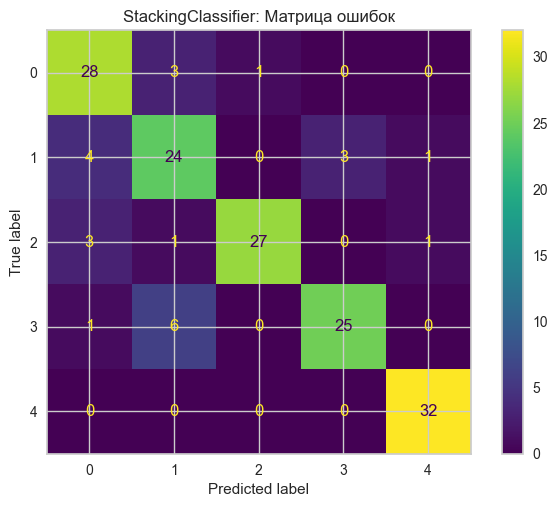

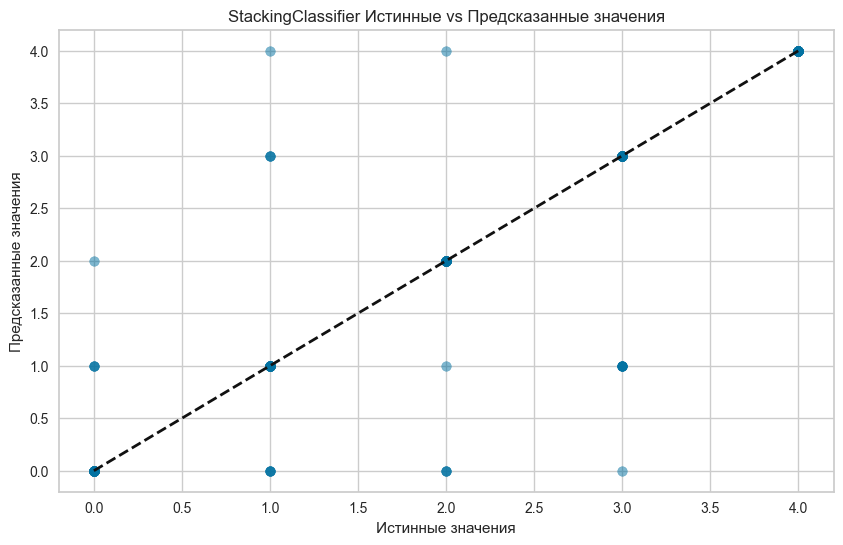

In [36]:
y_pred_Stacking_clf = Stacking_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_Stacking_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_Stacking_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('StackingClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_Stacking_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('StackingClassifier Истинные vs Предсказанные значения')
plt.show()

CatBoost

In [37]:
def optimize_CatBoost_clf(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'iterations': trial.suggest_int ('iterations', 100, 2000),
            'learning_rate': trial.suggest_float ('learning_rate', 0.1, 1),
            'depth': trial.suggest_int ('depth', 3, 15),
            'verbose': trial.suggest_categorical('verbose', [False]),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 30),
            #'subsample': trial.suggest_float('subsample', 0.6, 1) уменьшает переобучение
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1),
            'border_count': trial.suggest_int('border_count', 32, 100),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Depthwise', 'SymmetricTree']),
            'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 3)
        }

        model = cb.CatBoostClassifier(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_CatBoost_clf = optimize_CatBoost_clf(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
CatBoost_clf = cb.CatBoostClassifier(
            **best_CatBoost_clf
        )
CatBoost_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-22 08:30:28,586] A new study created in memory with name: no-name-3503cd34-c8a0-4473-a76e-955814357113
[I 2025-05-22 08:30:34,110] Trial 0 finished with value: 0.15000000000000002 and parameters: {'iterations': 812, 'learning_rate': 0.9556428757689246, 'depth': 12, 'verbose': False, 'random_state': 42, 'l2_leaf_reg': 18, 'colsample_bylevel': 0.6624074561769746, 'border_count': 42, 'min_data_in_leaf': 5, 'grow_policy': 'Depthwise', 'max_ctr_complexity': 3}. Best is trial 0 with value: 0.15000000000000002.
[I 2025-05-22 08:30:34,678] Trial 1 finished with value: 0.14375000000000004 and parameters: {'iterations': 139, 'learning_rate': 0.9729188669457949, 'depth': 13, 'verbose': False, 'random_state': 42, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.6727299868828402, 'border_count': 44, 'min_data_in_leaf': 9, 'grow_policy': 'Depthwise', 'max_ctr_complexity': 1}. Best is trial 1 with value: 0.14375000000000004.
[I 2025-05-22 08:30:37,140] Trial 2 finished with value: 0.15625 and para

R²: 0.7875


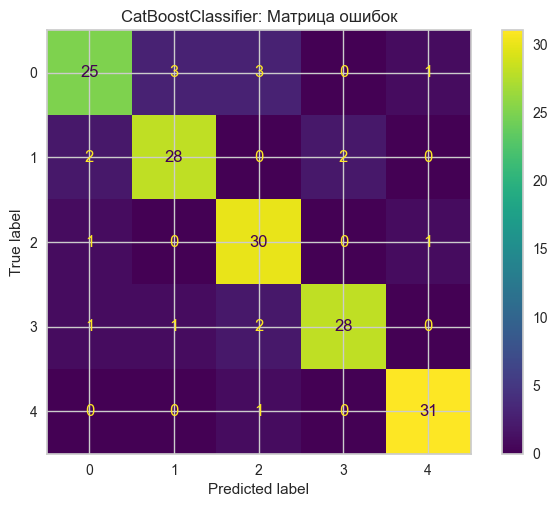

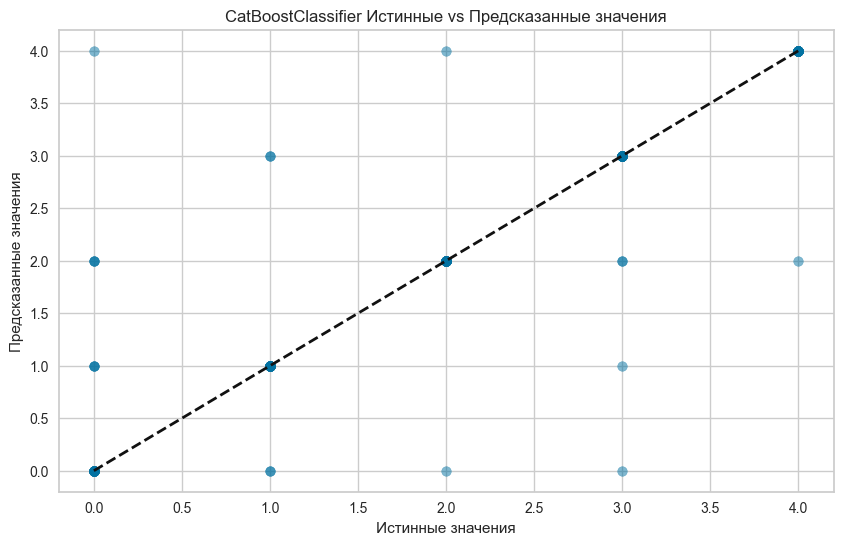

In [38]:
y_pred_CatBoost_clf = CatBoost_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_CatBoost_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_CatBoost_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('CatBoostClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_CatBoost_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('CatBoostClassifier Истинные vs Предсказанные значения')
plt.show()

In [39]:
def optimize_CatBoost_reg(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'loss_function': 'RMSE',
            'iterations': trial.suggest_int ('iterations', 100, 2000),
            'learning_rate': trial.suggest_float ('learning_rate', 0.005, 0.2),
            'depth': trial.suggest_int ('depth', 3, 15),
            'verbose': trial.suggest_categorical('verbose', [False]),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 30),
            #'subsample': trial.suggest_float('subsample', 0.6, 1) уменьшает переобучение
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1),
            'border_count': trial.suggest_int('border_count', 32, 100),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 20),
            'grow_policy': trial.suggest_categorical('grow_policy', ['Depthwise', 'SymmetricTree']),
            'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 3)
        }

        model = cb.CatBoostRegressor(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_CatBoost_reg = optimize_CatBoost_reg(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
CatBoost_reg = cb.CatBoostRegressor(
            **best_CatBoost_reg
        )
CatBoost_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-22 15:16:51,331] A new study created in memory with name: no-name-551f4796-81ff-45e5-b883-567e97593526
[I 2025-05-22 15:17:59,147] Trial 0 finished with value: 228885.54384142134 and parameters: {'iterations': 812, 'learning_rate': 0.19038928974993366, 'depth': 12, 'verbose': False, 'random_state': 42, 'l2_leaf_reg': 18, 'colsample_bylevel': 0.6624074561769746, 'border_count': 42, 'min_data_in_leaf': 5, 'grow_policy': 'Depthwise', 'max_ctr_complexity': 3}. Best is trial 0 with value: 228885.54384142134.
[I 2025-05-22 15:18:07,077] Trial 1 finished with value: 217401.9707578013 and parameters: {'iterations': 139, 'learning_rate': 0.1941324211715889, 'depth': 13, 'verbose': False, 'random_state': 42, 'l2_leaf_reg': 7, 'colsample_bylevel': 0.6727299868828402, 'border_count': 44, 'min_data_in_leaf': 9, 'grow_policy': 'Depthwise', 'max_ctr_complexity': 1}. Best is trial 1 with value: 217401.9707578013.
[I 2025-05-22 15:18:11,141] Trial 2 finished with value: 197712.0470637407 and

R²: 0.9827


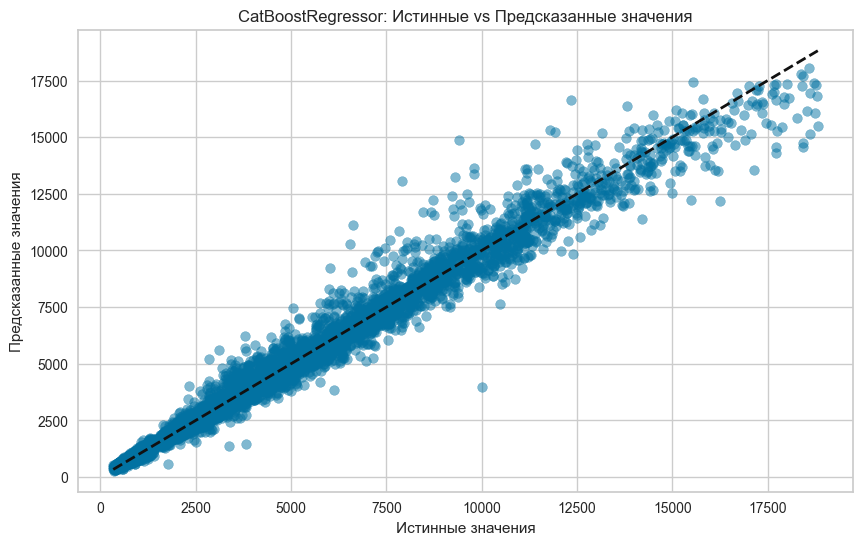

In [40]:
y_pred_CatBoost_reg = CatBoost_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_CatBoost_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_CatBoost_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('CatBoostRegressor: Истинные vs Предсказанные значения')
plt.show()

XGBoost

In [41]:
def optimize_XGBoost_clf(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'objective': 'multi:softprob',
            'num_class': 5,
            'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),   # L1 регуляризация
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 20), # L2 регуляризация
            'random_state': 42,
            'use_label_encoder': False,
            'verbosity': 0
        }

        model = xgb.XGBClassifier(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_XGBoost_clf = optimize_XGBoost_clf(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
XGBoost_clf = xgb.XGBClassifier(
            **best_XGBoost_clf
        )
XGBoost_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-22 15:24:51,119] A new study created in memory with name: no-name-1aee2824-5be0-425c-b6ff-777410d8c871
[I 2025-05-22 15:24:51,905] Trial 0 finished with value: 0.38749999999999996 and parameters: {'n_estimators': 437, 'learning_rate': 0.28546072039092524, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.15601864044243652, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 12.421185223120967}. Best is trial 0 with value: 0.38749999999999996.
[I 2025-05-22 15:24:53,147] Trial 1 finished with value: 0.35624999999999996 and parameters: {'n_estimators': 737, 'learning_rate': 0.01107242581726172, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.21233911067827616, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 10.97037220101252}. Best is trial 1 with value: 0.35624999999999996.
[I 2025-05-22 15:24:53,600] Trial 2 finished with value: 0.300

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7063541293321152, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.003832573664775499, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.25044575141169484, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=964, n_jobs=None,
              num_parallel_tree=None, ...)

R²: 0.6687


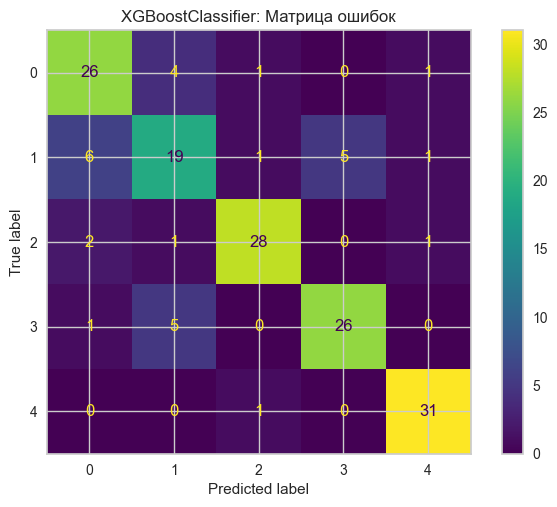

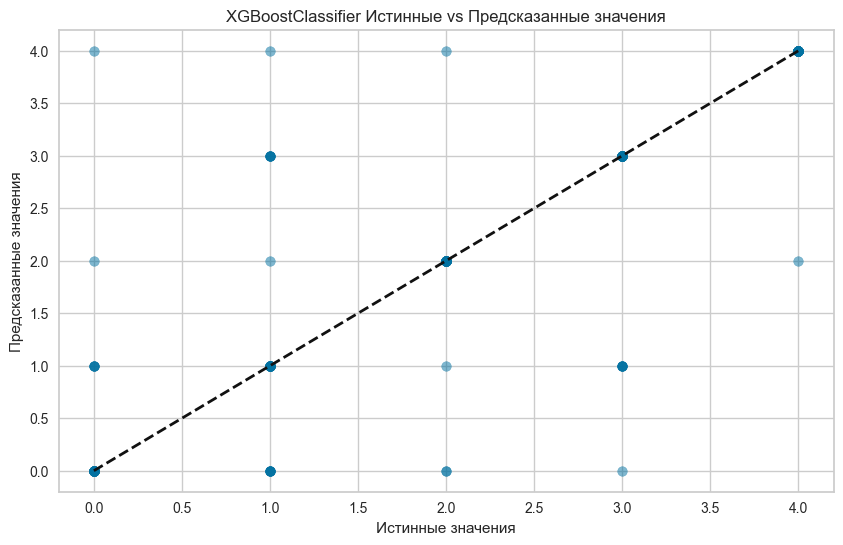

In [42]:
y_pred_XGBoost_clf = XGBoost_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_XGBoost_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_XGBoost_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('XGBoostClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_XGBoost_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('XGBoostClassifier Истинные vs Предсказанные значения')
plt.show()

In [43]:
def optimize_XGBoost_reg(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse', 
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3),
            'max_depth': trial.suggest_int('max_depth', 5, 15),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 20),
            'random_state': 42,
            'verbosity': 0
        }

        model = xgb.XGBRegressor(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_XGBoost_reg = optimize_XGBoost_reg(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
XGBoost_reg = xgb.XGBRegressor(
            **best_XGBoost_reg
        )
XGBoost_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-22 15:25:27,984] A new study created in memory with name: no-name-5f5541ec-6a6a-477e-b662-1196c82b8362
[I 2025-05-22 15:25:30,046] Trial 0 finished with value: 229217.57308803994 and parameters: {'n_estimators': 437, 'learning_rate': 0.28546072039092524, 'max_depth': 13, 'min_child_weight': 12, 'gamma': 0.15601864044243652, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 8.661761457749352, 'reg_lambda': 12.421185223120967}. Best is trial 0 with value: 229217.57308803994.
[I 2025-05-22 15:25:34,905] Trial 1 finished with value: 191908.88717509198 and parameters: {'n_estimators': 737, 'learning_rate': 0.01107242581726172, 'max_depth': 15, 'min_child_weight': 17, 'gamma': 0.21233911067827616, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'reg_alpha': 3.0424224295953772, 'reg_lambda': 10.97037220101252}. Best is trial 1 with value: 191908.88717509198.
[I 2025-05-22 15:25:37,942] Trial 2 finished with value: 194638.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8187787356776066, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.32518332202674705, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10261491733153151,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=661, n_jobs=None,
             num_parallel_tree=None, ...)

R²: 0.9835


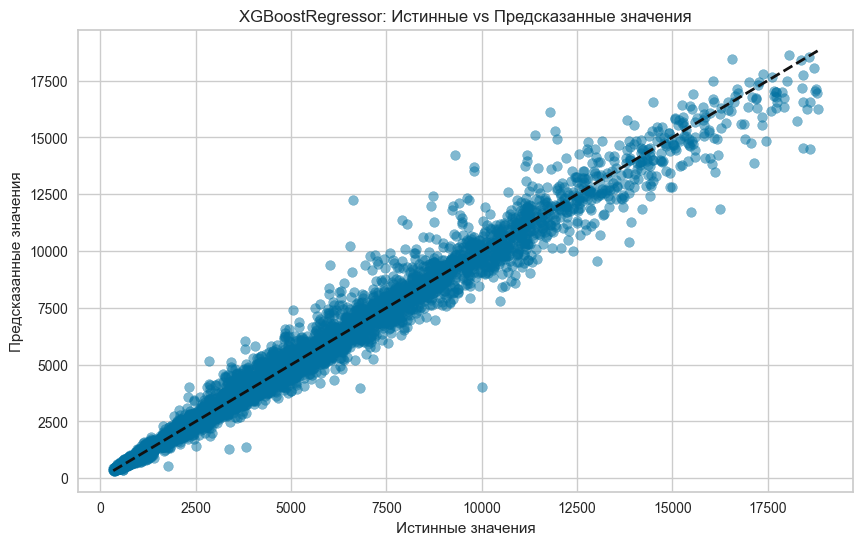

In [44]:
y_pred_XGBoost_reg = XGBoost_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_XGBoost_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_XGBoost_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('XGBoostRegressor: Истинные vs Предсказанные значения')
plt.show()

LightGBM

In [45]:
def optimize_LightGBM_clf(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'objective': 'multiclass',
            'num_class': 5,
            'metric': 'multi_logloss',
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 255),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'random_state': 42,
            'verbosity': -1
        }

        model = lgb.LGBMClassifier(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return 1 - accuracy_score(y_test, preds)  # минимизируем ошибку
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=50)
    return study.best_params

best_LightGBM_clf = optimize_LightGBM_clf(x_train_clf, y_train_clf, x_test_clf, y_test_clf)
LightGBM_clf = lgb.LGBMClassifier(
            **best_LightGBM_clf
        )
LightGBM_clf.fit(x_train_clf, y_train_clf)

[I 2025-05-22 15:25:50,294] A new study created in memory with name: no-name-d5e62c89-8eb1-423f-a317-0817ffa480f8
[I 2025-05-22 15:25:53,686] Trial 0 finished with value: 0.32499999999999996 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1001303991139125, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 19, 'min_child_weight': 0.0017073967431528124, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043, 'reg_alpha': 7.080725777960454, 'reg_lambda': 0.20584494295802447, 'n_estimators': 973}. Best is trial 0 with value: 0.32499999999999996.
[I 2025-05-22 15:25:54,352] Trial 1 finished with value: 0.29374999999999996 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010526458851636467, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 55, 'min_child_weight': 0.05342937261279776, 'subsample': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'reg_alpha': 1.3949386065204183, 'reg_lambda': 2.9214464853521815, 'n_estimators': 430

LGBMClassifier(boosting_type='dart', colsample_bytree=0.9995058978465143,
               learning_rate=0.2942961400691184, max_depth=12,
               min_child_samples=34, min_child_weight=0.2757080024357291,
               n_estimators=249, num_leaves=210, reg_alpha=0.21729103923468895,
               reg_lambda=5.821065909828388, subsample=0.680371010605396)

R²: 0.6813


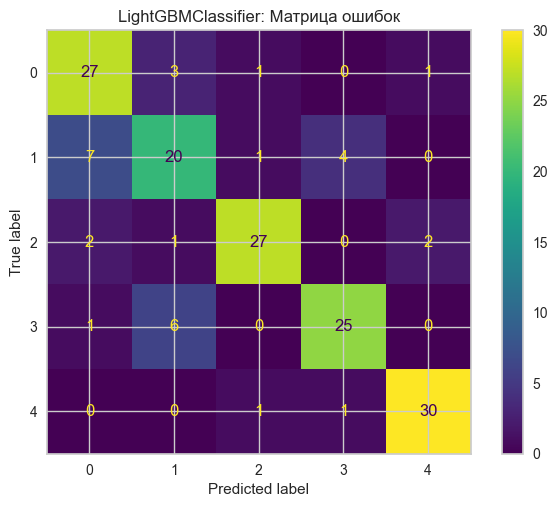

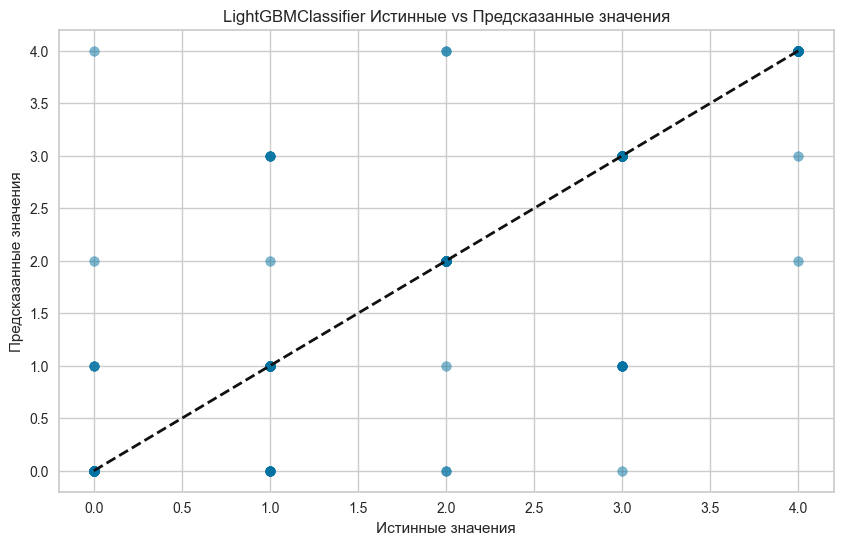

In [46]:
y_pred_LightGBM_clf = LightGBM_clf.predict(x_test_clf)

r2 = r2_score(y_test_clf, y_pred_LightGBM_clf)
print(f"R²: {r2:.4f}")

cm = confusion_matrix(y_test_clf, y_pred_LightGBM_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('LightGBMClassifier: Матрица ошибок')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test_clf, y_pred_LightGBM_clf, alpha=0.5)
plt.plot([y_test_clf.min(), y_test_clf.max()], [y_test_clf.min(), y_test_clf.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('LightGBMClassifier Истинные vs Предсказанные значения')
plt.show()

In [47]:
def optimize_LightGBM_reg(X_train, y_train, X_test, y_test):
    def objective(trial):
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 15, 255),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'random_state': 42,
            'verbosity': -1
        }

        model = lgb.LGBMRegressor(
            **params
        )
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_squared_error(y_test, preds)
     
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=10)
    return study.best_params

best_LightGBM_reg = optimize_LightGBM_reg(x_train_reg, y_train_reg, x_test_reg, y_test_reg)
LightGBM_reg = lgb.LGBMRegressor(
            **best_LightGBM_reg
        )
LightGBM_reg.fit(x_train_reg, y_train_reg)

[I 2025-05-22 15:26:44,248] A new study created in memory with name: no-name-7a4541a3-d831-4409-84b4-d66e3862b487
[I 2025-05-22 15:26:59,476] Trial 0 finished with value: 182376.0362882019 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.1001303991139125, 'num_leaves': 159, 'max_depth': 5, 'min_child_samples': 19, 'min_child_weight': 0.0017073967431528124, 'subsample': 0.9330880728874675, 'colsample_bytree': 0.8005575058716043, 'reg_alpha': 7.080725777960454, 'reg_lambda': 0.20584494295802447, 'n_estimators': 973}. Best is trial 0 with value: 182376.0362882019.
[I 2025-05-22 15:27:00,531] Trial 1 finished with value: 205110.70838106272 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010526458851636467, 'num_leaves': 59, 'max_depth': 6, 'min_child_samples': 55, 'min_child_weight': 0.05342937261279776, 'subsample': 0.645614570099021, 'colsample_bytree': 0.8059264473611898, 'reg_alpha': 1.3949386065204183, 'reg_lambda': 2.9214464853521815, 'n_estimators': 430}. Be

LGBMRegressor(boosting_type='dart', colsample_bytree=0.8005575058716043,
              learning_rate=0.1001303991139125, max_depth=5,
              min_child_samples=19, min_child_weight=0.0017073967431528124,
              n_estimators=973, num_leaves=159, reg_alpha=7.080725777960454,
              reg_lambda=0.20584494295802447, subsample=0.9330880728874675)

R²: 0.9841


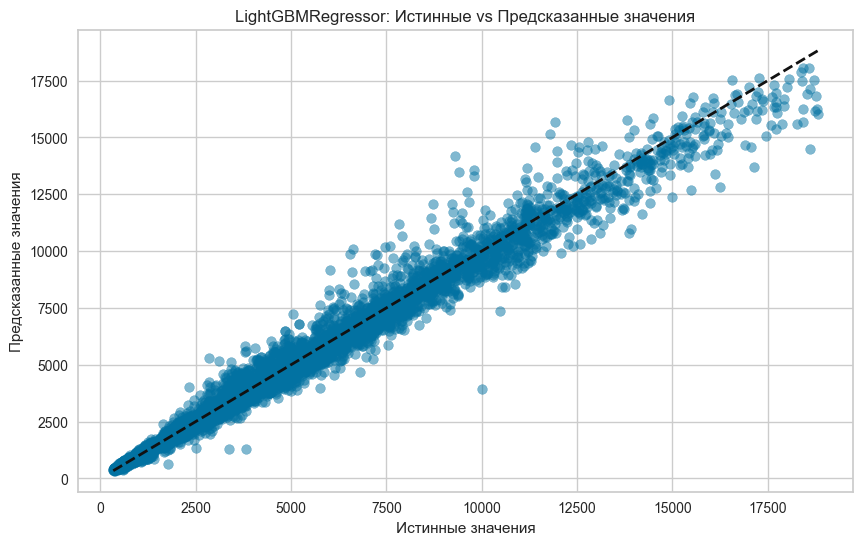

In [48]:
y_pred_LightGBM_reg = LightGBM_reg.predict(x_test_reg)

r2 = r2_score(y_test_reg, y_pred_LightGBM_reg)
print(f"R²: {r2:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_LightGBM_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('LightGBMRegressor: Истинные vs Предсказанные значения')
plt.show()

In [49]:
import pandas as pd
import numpy as np
from typing import List, Dict, Union
from sklearn.metrics import (
    # Метрики для классификации
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    # Метрики для регрессии
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score
)

def compare_models_custom_data(
    models: List[Dict[str, Union[str, object]]],
    round_digits: int = 2
) -> pd.DataFrame:
    results = []

    for model_info in models:
        # Получаем данные для текущей модели
        X_train = model_info['X_train']
        y_train = model_info['y_train']
        X_test = model_info['X_test']
        y_test = model_info['y_test']
        model = model_info['model']
        model_name = model_info['name']

        # Определяем тип задачи (регрессия или классификация)
        is_classification = 'Classifier' in model_name
        
        # Делаем предсказания
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Вычисляем метрики в зависимости от типа задачи
        if is_classification:
            # Метрики для классификации
            test_metrics = {
                "Test Accuracy": round(accuracy_score(y_test, y_test_pred), round_digits),
                "Test Precision": round(precision_score(y_test, y_test_pred, average="macro"), round_digits),
                "Test Recall": round(recall_score(y_test, y_test_pred, average="macro"), round_digits),
                "Test F1": round(f1_score(y_test, y_test_pred, average="macro"), round_digits),
            }
            
            train_metrics = {
                "Train Accuracy": round(accuracy_score(y_train, y_train_pred), round_digits),
                "Train Precision": round(precision_score(y_train, y_train_pred, average="macro"), round_digits),
                "Train Recall": round(recall_score(y_train, y_train_pred, average="macro"), round_digits),
                "Train F1": round(f1_score(y_train, y_train_pred, average="macro"), round_digits),
            }
        else:
            # Метрики для регрессии
            test_metrics = {
                "Test MSE": round(mean_squared_error(y_test, y_test_pred), round_digits),
                "Test RMSE": round(np.sqrt(mean_squared_error(y_test, y_test_pred)), round_digits),
                "Test MAE": round(mean_absolute_error(y_test, y_test_pred), round_digits),
                "Test R2": round(r2_score(y_test, y_test_pred), round_digits),
            }
            
            train_metrics = {
                "Train MSE": round(mean_squared_error(y_train, y_train_pred), round_digits),
                "Train RMSE": round(np.sqrt(mean_squared_error(y_train, y_train_pred)), round_digits),
                "Train MAE": round(mean_absolute_error(y_train, y_train_pred), round_digits),
                "Train R2": round(r2_score(y_train, y_train_pred), round_digits),
            }

        # Добавляем в результаты
        model_result = {
            "Model": model_name,
            "Type": "Classification" if is_classification else "Regression",
            **test_metrics,
            **train_metrics,
        }
        results.append(model_result)

    return pd.DataFrame(results)

In [53]:
dt_reg_k = DecisionTreeRegressor(**best_params_reg, random_state=42)
dt_reg_k.fit(X_train_reg, Y_train_reg)

dt_clf_k = DecisionTreeClassifier(**best_params_clf, random_state=42)
dt_clf_k.fit(X_train_clf, Y_train_clf)

bagging_reg_k = BaggingRegressor(**best_bagging_reg_an, random_state=42)
bagging_reg_k.fit(X_train_reg, Y_train_reg)

bagging_clf_k = BaggingClassifier(**best_bagging_clf, random_state=42)
bagging_clf_k.fit(X_train_clf, Y_train_clf)

GradientBoosting_reg_k = GradientBoostingRegressor(init=DecisionTreeRegressor(**best_params_reg), **best_GradientBoosting_reg, random_state=42)
GradientBoosting_reg_k.fit(X_train_reg, Y_train_reg)

GradientBoosting_clf_k = GradientBoostingClassifier(**best_GradientBoosting_clf, random_state=42)
GradientBoosting_clf_k.fit(X_train_clf, Y_train_clf)

Stacking_reg_k = StackingRegressor(
            estimators=base_estimators_reg,
            final_estimator=base_estimator_reg,
            **best_Stacking_reg
        )
Stacking_reg_k.fit(X_train_reg, Y_train_reg)

Stacking_clf_k = StackingClassifier(
            estimators=base_estimators_clf,
            final_estimator=base_estimator_clf,
            **best_Stacking_clf
        )
Stacking_clf_k.fit(X_train_clf, Y_train_clf)

CatBoost_clf_k = cb.CatBoostClassifier(
            **best_CatBoost_clf
        )
CatBoost_clf_k.fit(X_train_clf, Y_train_clf)

CatBoost_reg_k = cb.CatBoostRegressor(
            **best_CatBoost_reg
        )
CatBoost_reg_k.fit(X_train_reg, Y_train_reg)

XGBoost_clf_k = xgb.XGBClassifier(
            **best_XGBoost_clf
        )
XGBoost_clf_k.fit(X_train_clf, Y_train_clf)

XGBoost_reg_k = xgb.XGBRegressor(
            **best_XGBoost_reg
        )
XGBoost_reg_k.fit(X_train_reg, Y_train_reg)

LightGBM_clf_k = lgb.LGBMClassifier(
            **best_LightGBM_clf
        )
LightGBM_clf_k.fit(X_train_clf, Y_train_clf)

LightGBM_reg_k = lgb.LGBMRegressor(
            **best_LightGBM_reg
        )
LightGBM_reg_k.fit(X_train_reg, Y_train_reg)

LGBMRegressor(boosting_type='dart', colsample_bytree=0.8005575058716043,
              learning_rate=0.1001303991139125, max_depth=5,
              min_child_samples=19, min_child_weight=0.0017073967431528124,
              n_estimators=973, num_leaves=159, reg_alpha=7.080725777960454,
              reg_lambda=0.20584494295802447, subsample=0.9330880728874675)

In [54]:
bagging_clf_random_forest_k = BaggingClassifier(**best_bagging_clf_random_forest, random_state=42)
bagging_clf_random_forest_k.fit(X_train_clf, Y_train_clf)

bagging_reg_random_forest_k = BaggingRegressor(**best_bagging_reg_an_random_forest, random_state=42)
bagging_reg_random_forest_k.fit(X_train_reg, Y_train_reg)

BaggingRegressor(max_features=0.9729188669457949,
                 max_samples=0.1185260448662222, n_estimators=145,
                 random_state=42)

In [55]:
# Подготовка данных моделей
models_info = [
    {
        "name": "DecisionTreeRegressor",
        "model": dt_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "DecisionTreeClassifier",
        "model": dt_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "BaggingRegressor",
        "model": bagging_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "BaggingRegressorRandomForest",
        "model": bagging_reg_random_forest,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "BaggingClassifier",
        "model": bagging_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "BaggingClassifierRandomForest",
        "model": bagging_clf_random_forest,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "GradientBoostingRegressor",
        "model": GradientBoosting_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "GradientBoostingClassifier",
        "model": GradientBoosting_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "StackingRegressor",
        "model": Stacking_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "StackingClassifier",
        "model": Stacking_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "CatBoostRegressor",
        "model": CatBoost_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "CatBoostClassifier",
        "model": CatBoost_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "XGBoostRegressor",
        "model": XGBoost_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "XGBoostClassifier",
        "model": XGBoost_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },
    {
        "name": "LightGBMRegressor",
        "model": LightGBM_reg,
        "X_train": x_train_reg,
        "y_train": y_train_reg,
        "X_test": x_test_reg,
        "y_test": y_test_reg,
    },
    {
        "name": "LightGBMClassifier",
        "model": LightGBM_clf,
        "X_train": x_train_clf,
        "y_train": y_train_clf,
        "X_test": x_test_clf,
        "y_test": y_test_clf,
    },


    
    {
        "name": "DecisionTreeRegressor with k-fold",
        "model": dt_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "DecisionTreeClassifier with k-fold",
        "model": dt_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "BaggingRegressor with k-fold",
        "model": bagging_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "BaggingClassifier with k-fold",
        "model": bagging_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    }, 
    {
        "name": "BaggingRegressor With Random Forest with k-fold",
        "model": bagging_reg_random_forest_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "BaggingClassifier With Random Forest with k-fold",
        "model": bagging_clf_random_forest_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "GradientBoostingRegressor with k-fold",
        "model": GradientBoosting_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "GradientBoostingClassifier with k-fold",
        "model": GradientBoosting_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "StackingRegressor with k-fold",
        "model": Stacking_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "StackingClassifier with k-fold",
        "model": Stacking_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "CatBoostRegressor with k-fold",
        "model": CatBoost_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "CatBoostClassifier with k-fold",
        "model": CatBoost_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "XGBoostRegressor with k-fold",
        "model": XGBoost_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "XGBoostClassifier with k-fold",
        "model": XGBoost_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    },
    {
        "name": "LightGBMRegressor with k-fold",
        "model": LightGBM_reg_k,
        "X_train": X_train_reg,
        "y_train": Y_train_reg,
        "X_test": X_test_reg,
        "y_test": Y_test_reg,
    },
    {
        "name": "LightGBMClassifier with k-fold",
        "model": LightGBM_clf_k,
        "X_train": X_train_clf,
        "y_train": Y_train_clf,
        "X_test": X_test_clf,
        "y_test": Y_test_clf,
    }
]


# Создаем DataFrame с метриками
metrics_df = compare_models_custom_data(models_info, round_digits=2)
display(metrics_df)

,Model,Type,Test MSE,Test RMSE,Test MAE,Test R2,Train MSE,Train RMSE,Train MAE,Train R2,Test Accuracy,Test Precision,Test Recall,Test F1,Train Accuracy,Train Precision,Train Recall,Train F1
0,DecisionTreeRegressor,Regression,252109.83,502.11,268.99,0.98,150360.26,387.76,212.60,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DecisionTreeClassifier,Classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.72,0.73,0.72,0.72,0.99,0.99,0.99,0.99
2,BaggingRegressor,Regression,202815.99,450.35,230.79,0.98,35334.28,187.97,96.66,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BaggingRegressorRandomForest,Regression,237561.59,487.40,253.29,0.98,193377.72,439.75,229.20,0.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BaggingClassifier,Classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85,0.86,0.85,0.85,1.00,1.00,1.00,1.00
5,BaggingClassifierRandomForest,Classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86,0.86,0.86,0.86,1.00,1.00,1.00,1.00
6,GradientBoostingRegressor,Regression,239846.20,489.74,263.65,0.98,122125.85,349.47,199.88,0.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,GradientBoostingClassifier,Classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.81,0.81,0.81,0.81,1.00,1.00,1.00,1.00
8,StackingRegressor,Regression,188174.34,433.79,224.10,0.98,29628.45,172.13,101.50,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,StackingClassifier,Classification,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85,0.86,0.85,0.85,1.00,1.00,1.00,1.00


In [56]:
def compare_models_custom_data(
    models: List[Dict[str, Union[str, object]]],
    round_digits: int = 2
) -> Dict[str, pd.DataFrame]:
    classification_results = []
    regression_results = []

    for model_info in models:
        X_train = model_info['X_train']
        y_train = model_info['y_train']
        X_test = model_info['X_test']
        y_test = model_info['y_test']
        model = model_info['model']
        model_name = model_info['name']

        is_classification = 'Classifier' in model_name

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        if is_classification:
            test_metrics = {
                "Test Accuracy": round(accuracy_score(y_test, y_test_pred), round_digits),
                "Test Precision": round(precision_score(y_test, y_test_pred, average="macro"), round_digits),
                "Test Recall": round(recall_score(y_test, y_test_pred, average="macro"), round_digits),
                "Test F1": round(f1_score(y_test, y_test_pred, average="macro"), round_digits),
            }
            train_metrics = {
                "Train Accuracy": round(accuracy_score(y_train, y_train_pred), round_digits),
                "Train Precision": round(precision_score(y_train, y_train_pred, average="macro"), round_digits),
                "Train Recall": round(recall_score(y_train, y_train_pred, average="macro"), round_digits),
                "Train F1": round(f1_score(y_train, y_train_pred, average="macro"), round_digits),
            }
            model_result = {
                "Model": model_name,
                **test_metrics,
                **train_metrics
            }
            classification_results.append(model_result)
        else:
            test_metrics = {
                "Test MSE": round(mean_squared_error(y_test, y_test_pred), round_digits),
                "Test RMSE": round(np.sqrt(mean_squared_error(y_test, y_test_pred)), round_digits),
                "Test MAE": round(mean_absolute_error(y_test, y_test_pred), round_digits),
                "Test R2": round(r2_score(y_test, y_test_pred), round_digits),
            }
            train_metrics = {
                "Train MSE": round(mean_squared_error(y_train, y_train_pred), round_digits),
                "Train RMSE": round(np.sqrt(mean_squared_error(y_train, y_train_pred)), round_digits),
                "Train MAE": round(mean_absolute_error(y_train, y_train_pred), round_digits),
                "Train R2": round(r2_score(y_train, y_train_pred), round_digits),
            }
            model_result = {
                "Model": model_name,
                **test_metrics,
                **train_metrics
            }
            regression_results.append(model_result)

    return {
        "classification": pd.DataFrame(classification_results),
        "regression": pd.DataFrame(regression_results)
    }


In [57]:
results = compare_models_custom_data(models_info)

classification_df = results["classification"]
regression_df = results["regression"]
display(classification_df)
display(regression_df)

,Model,Test Accuracy,Test Precision,Test Recall,Test F1,Train Accuracy,Train Precision,Train Recall,Train F1
0,DecisionTreeClassifier,0.72,0.73,0.72,0.72,0.99,0.99,0.99,0.99
1,BaggingClassifier,0.85,0.86,0.85,0.85,1.00,1.00,1.00,1.00
2,BaggingClassifierRandomForest,0.86,0.86,0.86,0.86,1.00,1.00,1.00,1.00
3,GradientBoostingClassifier,0.81,0.81,0.81,0.81,1.00,1.00,1.00,1.00
4,StackingClassifier,0.85,0.86,0.85,0.85,1.00,1.00,1.00,1.00
5,CatBoostClassifier,0.89,0.89,0.89,0.89,1.00,1.00,1.00,1.00
6,XGBoostClassifier,0.81,0.81,0.81,0.81,1.00,1.00,1.00,1.00
7,LightGBMClassifier,0.81,0.81,0.81,0.81,1.00,1.00,1.00,1.00
8,DecisionTreeClassifier with k-fold,0.75,0.75,0.75,0.75,0.99,0.99,0.99,0.99
9,BaggingClassifier with k-fold,0.88,0.88,0.88,0.88,1.00,1.00,1.00,1.00


,Model,Test MSE,Test RMSE,Test MAE,Test R2,Train MSE,Train RMSE,Train MAE,Train R2
0,DecisionTreeRegressor,252109.83,502.11,268.99,0.98,150360.26,387.76,212.60,0.99
1,BaggingRegressor,202815.99,450.35,230.79,0.98,35334.28,187.97,96.66,1.00
2,BaggingRegressorRandomForest,237561.59,487.40,253.29,0.98,193377.72,439.75,229.20,0.98
3,GradientBoostingRegressor,239846.20,489.74,263.65,0.98,122125.85,349.47,199.88,0.99
4,StackingRegressor,188174.34,433.79,224.10,0.98,29628.45,172.13,101.50,1.00
5,CatBoostRegressor,197712.05,444.65,236.97,0.98,159850.01,399.81,224.12,0.99
6,XGBoostRegressor,189184.20,434.95,230.25,0.98,99789.29,315.89,188.91,0.99
7,LightGBMRegressor,182034.35,426.65,224.75,0.98,136767.19,369.82,204.76,0.99
8,DecisionTreeRegressor with k-fold,252109.83,502.11,268.99,0.98,150360.26,387.76,212.60,0.99
9,BaggingRegressor with k-fold,200713.98,448.01,230.08,0.98,34942.62,186.93,96.38,1.00


In [58]:
from pycaret.classification import *
clf = setup(data_clf, target="num", session_id=42)

,Description,Value
0,Session id,42
1,Target,num
2,Target type,Multiclass
3,Original data shape,"(293, 15)"
4,Transformed data shape,"(293, 15)"
5,Transformed train set shape,"(205, 15)"
6,Transformed test set shape,"(88, 15)"
7,Numeric features,14
8,Preprocess,True
9,Imputation type,simple


In [59]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6052,0.6674,0.6052,0.5990,0.5786,0.3414,0.3523,0.6460
lightgbm,Light Gradient Boosting Machine,0.6050,0.6618,0.6050,0.5882,0.5796,0.3455,0.3571,0.1210
rf,Random Forest Classifier,0.6002,0.6621,0.6002,0.5159,0.5391,0.2955,0.3165,0.0390
xgboost,Extreme Gradient Boosting,0.5998,0.6592,0.5998,0.5802,0.5708,0.3326,0.3430,0.1040
lda,Linear Discriminant Analysis,0.5852,0.0000,0.5852,0.5630,0.5596,0.3224,0.3330,0.0070
ridge,Ridge Classifier,0.5810,0.0000,0.5810,0.4790,0.5127,0.2556,0.2773,0.0070
qda,Quadratic Discriminant Analysis,0.5810,0.0000,0.5810,0.5062,0.5279,0.2645,0.2787,0.0060
et,Extra Trees Classifier,0.5607,0.6478,0.5607,0.4789,0.5117,0.2508,0.2604,0.0340
dt,Decision Tree Classifier,0.5469,0.5503,0.5469,0.5663,0.5460,0.2899,0.2952,0.0070
dummy,Dummy Classifier,0.5464,0.4000,0.5464,0.2989,0.3863,0.0000,0.0000,0.0060


In [60]:
from pycaret.regression import *
reg = setup(data_reg, target="price")

,Description,Value
0,Session id,6400
1,Target,price
2,Target type,Regression
3,Original data shape,"(51904, 12)"
4,Transformed data shape,"(51904, 12)"
5,Transformed train set shape,"(36332, 12)"
6,Transformed test set shape,"(15572, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [61]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,229.7993,186772.4389,431.4744,0.9839,0.0934,0.0698,1.8030
lightgbm,Light Gradient Boosting Machine,241.5364,197776.2114,444.0262,0.9830,0.1028,0.0785,0.1190
xgboost,Extreme Gradient Boosting,238.4706,203386.6152,450.3730,0.9825,0.0941,0.0700,0.0820
et,Extra Trees Regressor,231.6999,207131.5443,454.5086,0.9822,0.0904,0.0650,1.4160
rf,Random Forest Regressor,234.8587,213676.5219,461.5843,0.9816,0.0902,0.0648,2.7780
gbr,Gradient Boosting Regressor,287.9254,260576.3314,509.9563,0.9775,0.1339,0.0988,1.0190
dt,Decision Tree Regressor,315.6828,395171.2241,627.9362,0.9660,0.1237,0.0857,0.0730
knn,K Neighbors Regressor,354.0840,470740.5462,685.8097,0.9594,0.1341,0.1031,0.0660
lr,Linear Regression,704.4065,1091073.2616,1044.3552,0.9060,0.6320,0.3992,0.0130
ridge,Ridge Regression,707.8482,1098769.9234,1048.0010,0.9053,0.6449,0.4009,0.0120


Вывод:

- Наиболее эффективной моделью:
1. для регрессии оказалась LightGBMRegressor имеет наименьший Test MSE (182034.35), 
наименьший Test RMSE (426.65) и наименьший Test MAE (224.75) при Test R² = 0.98. Показатель Accuracy 0.83, Precision 0.83, Recall 0.83, F1 0.82, эти показатели являются максимальными среди моделей GNB, LR, SVC.
2. для классификации оказалась CatBoostClassifier имеет наибольший Test Accuracy - 0.89, Test Precision - 0.89, Test Recall - 0.89, Test F1 - 0.89. Эти показатели являются наибольшими среди остальных моделей.
  
- Выборка взятая с помощью K fold улучшила результаты предсказания, однако это явление не постоянно и при повторном запуске результаты k fold могут не отличаться от hold-out.

- По метрикам можно увидеть, что все модели для задачи классификации имеют эффект переобучения, вероятно это связаны с тем, что датасет содержит только 300 записей, а после устранения дисбаланса классов количество записей составило 600, это говорит о том, что половина всех записей являются синтетическими.

In [ ]:
import pickle

# 2. Сохранение GradientBoosting (Scikit-learn)
with open('RGR_GradientBoosting.pkl', 'wb') as f:
    pickle.dump(GradientBoosting_clf, f)

# 3. Сохранение CatBoost (используем встроенный метод)
CatBoost_clf.save_model('RGR_CatBoost.cbm')

# 4. Сохранение Bagging (Scikit-learn)
with open('RGR_bagging.pkl', 'wb') as f:
    pickle.dump(bagging_clf, f)

# 5. Сохранение Stacking (Scikit-learn)
with open('RGR_Stacking.pkl', 'wb') as f:
    pickle.dump(Stacking_clf, f)

In [ ]:
import joblib
import pandas as pd


# Тестовые данные
test_data = pd.DataFrame({
    'age': [65],
    'sex': [1],  # Male
    'cp': [4],  # Asymptomatic
    'trestbps': [180],
    'chol': [300],
    'fbs': [1],  # Yes
    'restecg': [1],  # ST-T abnormality
    'thalach': [140],
    'exang': [1],  # Yes
    'oldpeak': [3.5],
    'slope': [3],  # Downsloping
    'ca': [3],
    'thal': [6],  # Fixed Defect
    'AgeGroup': [4]  # 61+
})

# Предсказание
probs = GradientBoosting_clf.predict_proba(test_data)[0]
prob_disease = sum(probs[1:])  # Сумма вероятностей классов 1, 2, 3, 4
print(f"Вероятность болезни: {prob_disease:.1%}")

In [ ]:
print(GradientBoosting_clf.get_params())

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': test_data.columns,
    'Importance': GradientBoosting_clf.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance)

In [ ]:
from sklearn.preprocessing import binarize
y_proba = GradientBoosting_clf.predict_proba(test_data)[:, 1]
y_pred = binarize([y_proba], threshold=0.3)[0]  # Порог 30%
print("Adjusted prediction:", y_pred)